In [1]:
import pandas as pd

In [2]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [ ]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [4]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid_no_outliers.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [13]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [14]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


In [46]:
min_lat, max_lat = train_processed.lat.min(), train_processed.lat.max()
min_lon, max_lon = train_processed.lon.min(), train_processed.lon.max()

In [534]:
print('Rectangle of interest in train data: ', min_lat, max_lat, min_lon, max_lon)

NameError: name 'min_lat' is not defined

## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

### Make an image at certain timestamp 

In [10]:
def generate_image(spec_timestamp, input_data):
    data = np.zeros((round((LON_MAX_BOUND-LON_MIN_BOUND) / 0.0005)+1, round((LAT_MAX_BOUND-LAT_MIN_BOUND) / 0.0005)+1))
    for _, row in input_data[(input_data.timestamp==spec_timestamp)][['lat', 'lon', 'num_of_posts']].iterrows():
        lon, lat, n_posts = row.lon, row.lat, int(row.num_of_posts)
        try:
            data[round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005)] = int(row.num_of_posts)
           
        except Exception as e:
            print("Error!")
            # print(e)
            # print(lon, lat)
            # print(round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005))
    return data

In [6]:
# For image normalization
pixels_norm = train_processed_x.num_of_posts.max() # [(train_processed_x.timestamp=='2020-01-31 13:00:00')].num_of_posts.max()
pixels_norm 

540

In [11]:
from tqdm import tqdm
import numpy as np
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date) / np.timedelta64(1, 'h'))):
        yield start_date + timedelta(hours=n)

def generate_image_set(data, start_date=pd.Timestamp('2020-01-25T23'), end_date=pd.Timestamp('2020-01-25T23'), window_size=5):
    train_3d_images = []
    ground_truth = []
    # gt_dict = {}
    # end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=window_size-1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=window_size)
        ground_truth.append(generate_image(spec_timestamp=inner_end_date, input_data=data))
        # gt_dict[inner_end_date] = ground_truth[-1]
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date # , gt_dict

In [15]:
valid_X, valid_y, last_date = generate_image_set(data=valid_no_outliers, start_date=pd.Timestamp('2020-02-01T09'), end_date=pd.Timestamp('2020-02-29T22'))

100%|██████████| 681/681 [00:04<00:00, 153.90it/s]


In [495]:
train_processed_x.to_pickle('./train_processed.pickle')

In [2]:
train_processed_x = pd.read_pickle('./train_processed.pickle')

In [61]:
valid_no_outliers.to_pickle('./valid_processed.pickle')

In [3]:
valid_no_outliers = pd.read_pickle('./valid_processed.pickle')

In [ ]:

train_X_0, train_y_0, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2019-04-09T23'))
np.save('./tw_5_train_data/train_X_0.npy', train_X_0)
np.save('./tw_5_train_data/train_y_0.npy', train_y_0)
print(last_date)

 28%|██▊       | 665/2371 [02:26<07:34,  3.76it/s]

In [ ]:
train_X_1, train_y_1, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-04-09T19'), end_date=pd.Timestamp('2019-07-17T22'))
np.save('./tw_5_train_data/train_X_1.npy', train_X_1)
np.save('./tw_5_train_data/train_y_1.npy', train_y_1)
print(last_date)

In [ ]:
train_X_2, train_y_2, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-07-17T18'), end_date=pd.Timestamp('2019-10-24T21'))
np.save('./tw_5_train_data/train_X_2.npy', train_X_2)
np.save('./tw_5_train_data/train_y_2.npy', train_y_2)
print(last_date)

In [15]:
train_X_3, train_y_3, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-10-24T17'), end_date=pd.Timestamp('2020-01-31T19'))
np.save('./tw_5_train_data/train_X_3.npy', train_X_3)
np.save('./tw_5_train_data/train_y_3.npy', train_y_3)
print(last_date)

100%|██████████| 2374/2374 [10:53<00:00,  3.63it/s]


2020-01-31 14:00:00


In [185]:
train_processed_x.sort_values('timestamp')

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01 00:00:00,1
146,30.464117,59.870670,0101000020E61000009BC66060D0763E40ABD94A1972EF...,2019-01-01 00:00:00,3
147,30.322632,59.933737,0101000020E61000009E01B90998523E407AB3D8B484F7...,2019-01-01 00:00:00,1
148,30.322632,59.938238,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,2019-01-01 00:00:00,1
149,30.322632,59.935988,0101000020E61000009E01B90998523E40E4A1F770CEF7...,2019-01-01 00:00:00,1
...,...,...,...,...,...
3570975,30.324878,59.941612,0101000020E61000005DECCB372B533E406DAFAAC186F8...,2020-01-31 23:00:00,2
3570976,30.324878,59.933737,0101000020E61000005DECCB372B533E407AB3D8B484F7...,2020-01-31 23:00:00,1
3570977,30.324878,59.917982,0101000020E61000005DECCB372B533E40D45E236C80F5...,2020-01-31 23:00:00,1
3570979,30.315895,59.937113,0101000020E61000006141807FDE503E400C288C4EF3F7...,2020-01-31 23:00:00,1


In [190]:
train_processed_x[train_processed_x.timestamp=='2020-01-31 23:00:00'].num_of_posts.sum()

299

In [77]:
train_X_0, train_X_1, train_X_2, train_X_3 = np.load('./train_X_0.npy'), np.load('./train_X_1.npy'), np.load('./train_X_2.npy'), np.load('./train_X_3.npy')
train_y_0, train_y_1, train_y_2, train_y_3 = np.load('./train_y_0.npy'), np.load('./train_y_1.npy'), np.load('./train_y_2.npy'), np.load('./train_y_3.npy')

In [79]:
train_X = list(train_X_0)+list(train_X_1)+list(train_X_2)+list(train_X_3)

In [80]:
train_y = list(train_y_0)+list(train_y_1)+list(train_y_2)+list(train_y_3)

In [5]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Concatenate, MaxPooling2D, UpSampling2D, ConvLSTM2D
import keras 

# def get_unet_model(img_size):

#     inputs = keras.Input(shape=img_size+(5, 1))
    
#     # --- Encoder ---
#     # first conv layer
#     conv_layer_1_1 = Conv3D(10, (1, 1, 3), activation=None, padding='valid')(inputs)
#     act1= tf.keras.activations.elu(conv_layer_1_1, alpha=0.0)
#     conv_layer_1_2 = Conv3D(20, (1, 1, 3), activation=None, padding='valid')(act1)
#     act2= tf.keras.activations.elu(conv_layer_1_2, alpha=0.0)
#     conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='sigmoid', padding='same')(act2)
#     act3= tf.keras.activations.elu(conv_layer_1_3, alpha=0.0)
    
#     conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='sigmoid', padding='same')(act3)
#     act4= tf.keras.activations.elu(conv_layer_2_1, alpha=0.0)
#     conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='sigmoid', padding='same')(act4)
#     act5= tf.keras.activations.elu(conv_layer_2_2, alpha=0.0)
#     outputs = Conv3D(1, 1, activation='sigmoid', padding='same')(act5)
    
#     model = keras.Model(inputs, outputs)
#     return model

def get_3d_lstm(img_size):

    inputs = keras.Input(shape=(5, )+ img_size+(1, ))
    
    # --- Encoder ---
    # first conv layer
    # inputs_pad = tf.keras.layers.ZeroPadding3D(padding=(1, 1, 0), data_format=None)(inputs)
    conv_layer_1_1 = ConvLSTM2D(3, (3, 3), activation='relu', padding='same', return_sequences=True)(inputs)
    conv_layer_1_2 = tf.keras.layers.ZeroPadding3D(padding=(0, 1, 1), data_format=None)(conv_layer_1_1)
    conv_layer_1_3 = Conv3D(7, (3, 3, 3), activation='relu', padding='valid')(conv_layer_1_2)
    # conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    
    # conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    # conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    outputs = Conv3D(1, (3, 1, 1), activation='relu', padding='valid')(conv_layer_1_3)
    model = keras.Model(inputs, outputs)
    return model

def get_unet_model(img_size):

    inputs = keras.Input(shape=img_size+(5, 1))
    
    # --- Encoder ---
    # first conv layer
    inputs_pad = tf.keras.layers.ZeroPadding3D(padding=(1, 1, 0), data_format=None)(inputs)
    conv_layer_1_1 = Conv3D(3, (3, 3, 3), activation='relu', padding='valid')(inputs_pad)
    conv_layer_1_1 = tf.keras.layers.ZeroPadding3D(padding=(1, 1, 0), data_format=None)(conv_layer_1_1)
    conv_layer_1_2 = Conv3D(7, (3, 3, 3), activation='relu', padding='valid')(conv_layer_1_1)
    # conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    
    # conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    # conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='relu', padding='same')(conv_layer_1_2)
    outputs = Conv3D(1, 1, activation='relu', padding='same')(conv_layer_1_2)
    
    model = keras.Model(inputs, outputs)
    return model



2022-11-17 12:41:52.852369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from tensorflow import keras
import tensorflow as tf


class ImgSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.target_paths = target_paths
        
    
    def __len__(self):
        length = 0
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths) // self.batch_size
        return length
    
    def __getitem__(self, idx):
        
        # TODO x and y calculation
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # for usual cnn
#         x = np.array([np.array(file_name).reshape((787, 422, -1, 1)) for file_name in batch_x])
#         y = np.array([np.expand_dims(np.array(file_name), axis=(2, 3)) for file_name in batch_y])
        
        # for 3d lstm 
        x = np.array([np.array(file_name).reshape((-1, 787, 422, 1)) for file_name in batch_x])
        y = np.array([np.expand_dims(np.array(file_name), axis=(0, 3)) for file_name in batch_y])
        return x, y 
        

        

In [71]:
# train_X = np.load('./tw_5_train_data/train_X_0.npy')
# train_y = np.load('./tw_5_train_data/train_y_0.npy')

2022-11-16 14:34:51.272983: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_20 in the registry.
Traceback (most recent call last):

  File "/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_20 in the registry.


2022-11-16 14:34:51.273336: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_20 in the registry.
Traceback (most recent call last):

  File "/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not fin

KeyboardInterrupt: 

In [13]:
train_X.shape

(2371, 5, 787, 422)

In [77]:
train_y.shape

(2371, 787, 422)

In [76]:
np.array(valid_X).shape

(681, 5, 787, 422)

In [78]:
np.array(valid_y).shape

(681, 787, 422)

In [17]:
# Instantiate data Sequences for each split
batch_size = 16
# train_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[:500], target_paths=train_y[:500])
valid_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=valid_X[:200], target_paths=valid_y[:200])

In [17]:
np.array(valid_X[18])[0, :, :].max()

0.0

In [74]:
train_gen.__getitem__(1)[0][2].shape

(5, 787, 422, 1)

In [75]:
valid_gen.__getitem__(1)[0][2].shape

(5, 787, 422, 1)

In [187]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model((787, 422))

In [188]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5, name="Adadelta"), loss=tf.keras.losses.MeanAbsolutePercentageError())

In [189]:

filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[history_logger])

Epoch 1/3


2022-11-16 15:54:42.676669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model/conv3d_1/Conv3D/Shape' exist for missing node 'model/zero_padding3d_1/Pad'.


31/31 [==============================] - 27s 848ms/step - loss: 3098430.5000 - val_loss: 33785.5352
Epoch 2/3
31/31 [==============================] - 27s 879ms/step - loss: 661676.1250 - val_loss: 15979.4365
Epoch 3/3
31/31 [==============================] - 26s 833ms/step - loss: 267646.4688 - val_loss: 9138.3779


In [127]:

filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[history_logger])

Epoch 1/3


2022-11-16 15:26:30.285140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model/conv3d/Conv3D/Shape' exist for missing node 'model/zero_padding3d/Pad'.


31/31 [==============================] - 86s 3s/step - loss: 42868.1953 - val_loss: 848.0156
Epoch 2/3
31/31 [==============================] - 81s 3s/step - loss: 2653.4832 - val_loss: 501.8445
Epoch 3/3
31/31 [==============================] - 86s 3s/step - loss: 912.0141 - val_loss: 343.6389


In [104]:
# model.save("./model.h5")
model = keras.models.load_model('./3d_lstm.h5')

In [105]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 787, 422, 1)]  0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 5, 787, 422, 3)    444       
                                                                 
 zero_padding3d (ZeroPadding  (None, 5, 789, 424, 3)   0         
 3D)                                                             
                                                                 
 conv3d (Conv3D)             (None, 3, 787, 422, 7)    574       
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 787, 422, 1)    22        
                                                                 
Total params: 1,040
Trainable params: 1,040
Non-trainable params: 0
___________________________________________________________

## Read test data

In [52]:
test = pd.read_csv('./test.csv')

In [54]:
print('Test before dropping duplicates:', test.shape)
test = test.drop_duplicates()
print('Test after dropping duplicates:', test.shape)

Test before dropping duplicates: (700, 6)
Test after dropping duplicates: (700, 6)


In [58]:
test['timestamp'] = pd.to_datetime(test['hour'], unit='s')

In [201]:
test.sort_values('timestamp')

,hour,lat,lon,point,num_of_posts,error,timestamp
417,1580536800,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,7,1.088069,2020-02-01 06:00:00
641,1580536800,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,8,2.754735,2020-02-01 06:00:00
171,1580544000,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,13,0.379735,2020-02-01 08:00:00
167,1580551200,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,0.254735,2020-02-01 10:00:00
64,1580551200,60.039332,30.322632,0101000020E61000009E01B90998523E40888919D70805...,7,5.754735,2020-02-01 10:00:00
...,...,...,...,...,...,...,...
353,1583002800,59.921359,30.468609,0101000020E6100000199C86BCF6773E401FBF4913EFF5...,19,0.565399,2020-02-29 19:00:00
496,1583002800,59.934863,30.342845,0101000020E6100000544263A8C4573E40DB251193A9F7...,12,2.754735,2020-02-29 19:00:00
499,1583002800,60.022505,30.338353,0101000020E6100000D86C3D4C9E563E408F79686EE102...,6,0.254735,2020-02-29 19:00:00
436,1583006400,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,37,2.865846,2020-02-29 20:00:00


In [59]:
# Drop all cubes that are not included in rectangle of interest
test_processed = test[((test.lat <= LAT_MAX_BOUND)&(test.lat >= LAT_MIN_BOUND)&(test.lon <= LON_MAX_BOUND)&(test.lon >= LON_MIN_BOUND))]
print('Test after removing cubes which are out of rectangle of interest: ', test_processed.shape)

Test after removing cubes which are out of rectangle of interest:  (700, 7)


In [68]:

test_processed = test_processed.rename({'sum': 'num_of_posts'}, axis=1)

In [69]:
test_X, test_y, last_date = generate_image_set(data=test_processed, start_date=pd.Timestamp('2020-02-01T06'), end_date=pd.Timestamp('2020-02-29T21'))

100%|██████████| 683/683 [00:04<00:00, 148.15it/s]


In [70]:
test_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=test_X, target_paths=test_y)

In [181]:
for i in range(16):
    to_pred = np.expand_dims(test_gen.__getitem__(19)[0][i].reshape(-1, 787, 422, 1), axis=0) * 540

    y_pred1 = model.predict(to_pred)[0, 0, :, :, 0]
    y_true = test_gen.__getitem__(19)[1][i][:, :, 0, 0]
    print(np.mean(abs(y_pred1 - y_true) / (y_pred1+1)))
    print('True: ', y_true.max(axis=0).max())
    print("Predicted: ", y_pred1.max(axis=0).max())
    
    # print(model.predict(np.random.rand(1, 5, 787,422, 1)))

1/1 [==============================] - 0s 83ms/step
0.0
True:  0.0
Predicted:  0.0
1/1 [==============================] - 0s 82ms/step
0.0
True:  0.0
Predicted:  0.0
1/1 [==============================] - 0s 80ms/step
1.5055071451369109e-05
True:  5.0
Predicted:  0.0
1/1 [==============================] - 0s 99ms/step
3.44805589905859e-05
True:  7.0
Predicted:  24.896063
1/1 [==============================] - 0s 78ms/step
1.464168731192154e-05
True:  11.0
Predicted:  34.904587
1/1 [==============================] - 0s 125ms/step
2.5373163760619834e-05
True:  5.0
Predicted:  8.587701
1/1 [==============================] - 0s 87ms/step
6.676222423297525e-05
True:  8.0
Predicted:  24.896063
1/1 [==============================] - 0s 87ms/step
7.086108776858237e-05
True:  7.0
Predicted:  39.908855
1/1 [==============================] - 0s 93ms/step
5.024466582690285e-05
True:  5.0
Predicted:  61.098198
1/1 [==============================] - 0s 74ms/step
7.734611904947086e-05
True:  8.0
Pred

In [180]:
for i in range(16):
    to_pred = np.expand_dims(test_gen.__getitem__(19)[0][i].reshape(-1, 787, 422, 1), axis=0)

    y_pred1 = model.predict(to_pred)[0, 0, :, :, 0]
    y_true = test_gen.__getitem__(19)[1][i][:, :, 0, 0]
    print(np.mean(abs(y_pred1 - y_true) / (y_pred1+1)))
    print('True: ', y_true.max(axis=0).max())
    print("Predicted: ", y_pred1.max(axis=0).max())
    
    # print(model.predict(np.random.rand(1, 5, 787,422, 1)))

1/1 [==============================] - 0s 79ms/step
0.0
True:  0.0
Predicted:  0.0
1/1 [==============================] - 0s 66ms/step
0.0
True:  0.0
Predicted:  0.0
1/1 [==============================] - 0s 105ms/step
1.5055071451369109e-05
True:  5.0
Predicted:  0.0
1/1 [==============================] - 0s 71ms/step
2.1077100031916752e-05
True:  7.0
Predicted:  0.0
1/1 [==============================] - 0s 73ms/step
3.3121157193012035e-05
True:  11.0
Predicted:  0.0
1/1 [==============================] - 0s 78ms/step
1.5055071451369109e-05
True:  5.0
Predicted:  0.0
1/1 [==============================] - 0s 84ms/step
3.9143185773559684e-05
True:  8.0
Predicted:  0.0
1/1 [==============================] - 0s 75ms/step
2.1077100031916752e-05
True:  7.0
Predicted:  0.0
1/1 [==============================] - 0s 71ms/step
1.5055071451369109e-05
True:  5.0
Predicted:  0.0
1/1 [==============================] - 0s 68ms/step
3.9143185773559684e-05
True:  8.0
Predicted:  0.0
1/1 [===========

In [130]:
np.nonzero(np.argmax(y_pred1, axis=1))

(array([131, 132, 133, 134, 418, 420, 421, 422, 423, 425, 426, 428, 430,
        469, 470, 471, 474, 492, 493, 494, 495, 530, 531, 532]),)

In [177]:
no_zero_true = valid_gen.__getitem__(7)[1][14][0, :, :, 0] 
# no_zero_true = no_zero_true[np.where(no_zero_true!=0)]

In [129]:
np.nonzero(np.argmax(y_true, axis=1))

(array([436, 485, 674]),)

In [153]:
np.argmax(np.argmax(y_pred1, axis=1))

532

In [155]:
y_pred1[530:540, 370:380]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  1.9944952 ,
         1.7347796 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.11838948,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        12.820243  ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

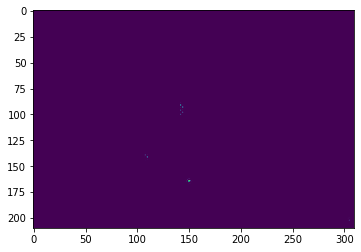

In [171]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(y_pred1[330:540, 70:380], interpolation='lanczos')
plt.show()

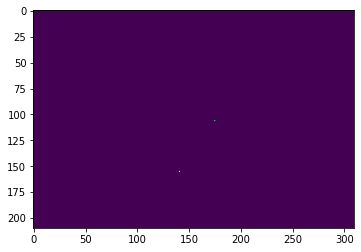

In [170]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(y_true[330:540, 70:380], interpolation='lanczos')
plt.show()

## Generate prediction of new data

In [186]:
def generate_prediction_image_set(data, start_date=pd.Timestamp('2020-01-31T18'), end_date=pd.Timestamp('2020-01-31T23')):
    train_3d_images = []
    ground_truth = []
    three_d_image = []
    for single_date in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        three_d_image.append(generate_image(spec_timestamp=single_date, input_data=data))
    return three_d_image

In [187]:
last_sample = generate_prediction_image_set(train_processed_x, start_date=pd.Timestamp('2020-01-31T19'), end_date=pd.Timestamp('2020-01-31T23'))

100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


In [325]:
np.array(last_sample).max()

41.0

In [324]:
last_sample[0].max(0)

array([ 8.,  0.,  1.,  0.,  3.,  0.,  0.,  1.,  0.,  4.,  0.,  2.,  0.,
       18.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  6.,  0.,  1.,  0.,  1.,
        0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
        7.,  0.,  4.,  0.,  1.,  0., 20.,  0.,  0.,  1.,  0.,  7.,  0.,
        3.,  0.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,  3.,  0.,  2.,  0.,
        0.,  3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  4.,
        0.,  0.,  6.,  0.,  2.,  0.,  2.,  0.,  3.,  0., 12.,  0.,  0.,
        4.,  0.,  1.,  0.,  3.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,
        1.,  0.,  5.,  0.,  0.,  2.,  0.,  3.,  0., 10.,  0.,  6.,  0.,
        0.,  1.,  0.,  3.,  0.,  3.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,
        0.,  2.,  0.,  4.,  0.,  0.,  2.,  0.,  4.,  0.,  3.,  0.,  2.,
        0.,  0.,  1.,  0.,  1.,  0.,  2.,  0., 12.,  0.,  0., 14

In [280]:
pred = model.predict(np.expand_dims(np.array(last_sample).reshape(-1, 787, 422, 1), axis=0)*540.) # TODO: remove *100

1/1 [==============================] - 0s 80ms/step


In [281]:
pred[0, 0, :, :, 0].max()

116.1239

In [284]:
np.array([[1, 3, 4], [23, 35, 2]]) * 3

array([[  3,   9,  12],
       [ 69, 105,   6]])

In [294]:
test_processed.num_of_posts.max()

40

In [442]:
def test(start_date=pd.Timestamp('2020-02-01T01'), end_date=pd.Timestamp('2020-02-29T21'), last_sample=np.array([])):
    predictions = []
    predictions_with_ts = {}
    last_sample = np.expand_dims(np.array(last_sample).reshape((-1, 787, 422, 1)), axis=0) # TODO: remove *100
    inp_ = last_sample.copy()
    val_preds = model.predict(inp_*540)
    predictions.append(val_preds)
    counter = 4
    for ts in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        
        last_sample = last_sample[:, -4:, :, :, :]
        last_sample = np.append(last_sample, val_preds, axis=1)
        inp_ = last_sample.copy()
        print(inp_.max())
        val_preds = model.predict(inp_*540)
        predictions.append(val_preds)
        predictions_with_ts[ts] = val_preds
    return predictions, predictions_with_ts

In [443]:
p , p_ts = test(last_sample=last_sample)

1/1 [==============================] - 0s 148ms/step


  0%|          | 0/693 [00:00<?, ?it/s]

116.1239013671875
1/1 [==============================] - 0s 314ms/step


  0%|          | 1/693 [00:00<04:57,  2.33it/s]

461.7520751953125
1/1 [==============================] - 0s 247ms/step


  0%|          | 2/693 [00:00<04:37,  2.49it/s]

2524.6005859375
1/1 [==============================] - 0s 352ms/step


  0%|          | 3/693 [00:01<05:01,  2.29it/s]

2524.6005859375
1/1 [==============================] - 0s 230ms/step


  1%|          | 4/693 [00:01<04:31,  2.54it/s]

5193.85595703125
1/1 [==============================] - 0s 218ms/step


  1%|          | 5/693 [00:01<04:11,  2.73it/s]

7157.9716796875
1/1 [==============================] - 0s 218ms/step


  1%|          | 6/693 [00:02<04:00,  2.85it/s]

7157.9716796875
1/1 [==============================] - 0s 165ms/step


  1%|          | 7/693 [00:02<03:47,  3.01it/s]

17016.021484375
1/1 [==============================] - 0s 220ms/step


  1%|          | 8/693 [00:02<03:47,  3.01it/s]

23801.703125
1/1 [==============================] - 0s 214ms/step


  1%|▏         | 9/693 [00:03<03:47,  3.01it/s]

23801.703125
1/1 [==============================] - 0s 212ms/step


  1%|▏         | 10/693 [00:03<03:49,  2.98it/s]

104785.96875
1/1 [==============================] - 0s 111ms/step


  2%|▏         | 11/693 [00:03<03:35,  3.17it/s]

216338.828125
1/1 [==============================] - 0s 170ms/step


  2%|▏         | 12/693 [00:04<03:31,  3.22it/s]

216410.9375
1/1 [==============================] - 0s 119ms/step


  2%|▏         | 13/693 [00:04<03:21,  3.37it/s]

510604.96875
1/1 [==============================] - 0s 129ms/step


  2%|▏         | 14/693 [00:04<03:04,  3.68it/s]

666909.0625
1/1 [==============================] - 0s 100ms/step


  2%|▏         | 15/693 [00:04<02:46,  4.08it/s]

936081.75
1/1 [==============================] - 0s 103ms/step


  2%|▏         | 16/693 [00:04<02:33,  4.41it/s]

3934538.25
1/1 [==============================] - 0s 96ms/step


  2%|▏         | 17/693 [00:05<02:24,  4.69it/s]

7621739.0
1/1 [==============================] - 0s 129ms/step


  3%|▎         | 18/693 [00:05<02:24,  4.68it/s]

7621739.0
1/1 [==============================] - 0s 115ms/step


  3%|▎         | 19/693 [00:05<02:21,  4.77it/s]

7621739.0
1/1 [==============================] - 0s 106ms/step


  3%|▎         | 20/693 [00:05<02:17,  4.88it/s]

49165388.0
1/1 [==============================] - 0s 113ms/step


  3%|▎         | 21/693 [00:05<02:16,  4.92it/s]

49165388.0
1/1 [==============================] - 0s 110ms/step


  3%|▎         | 22/693 [00:06<02:14,  5.00it/s]

49165388.0
1/1 [==============================] - 0s 103ms/step


  3%|▎         | 23/693 [00:06<02:16,  4.92it/s]

49165388.0
1/1 [==============================] - 0s 131ms/step


  3%|▎         | 24/693 [00:06<02:20,  4.75it/s]

190375360.0
1/1 [==============================] - 0s 121ms/step


  4%|▎         | 25/693 [00:06<02:20,  4.77it/s]

533494816.0
1/1 [==============================] - 0s 98ms/step


  4%|▍         | 26/693 [00:06<02:15,  4.93it/s]

2626441216.0
1/1 [==============================] - 0s 129ms/step


  4%|▍         | 27/693 [00:07<02:16,  4.88it/s]

4478142976.0
1/1 [==============================] - 0s 109ms/step


  4%|▍         | 28/693 [00:07<02:15,  4.91it/s]

4478142976.0
1/1 [==============================] - 0s 124ms/step


  4%|▍         | 29/693 [00:07<02:16,  4.86it/s]

4478142976.0
1/1 [==============================] - 0s 94ms/step


  4%|▍         | 30/693 [00:07<02:11,  5.05it/s]

6562645504.0
1/1 [==============================] - 0s 97ms/step


  4%|▍         | 31/693 [00:07<02:06,  5.24it/s]

9425149952.0
1/1 [==============================] - 0s 110ms/step


  5%|▍         | 32/693 [00:08<02:10,  5.06it/s]

9425149952.0
1/1 [==============================] - 0s 147ms/step


  5%|▍         | 33/693 [00:08<02:16,  4.82it/s]

16118469632.0
1/1 [==============================] - 0s 98ms/step


  5%|▍         | 34/693 [00:08<02:12,  4.98it/s]

26100508672.0
1/1 [==============================] - 0s 112ms/step


  5%|▌         | 35/693 [00:08<02:12,  4.98it/s]

26100508672.0
1/1 [==============================] - 0s 106ms/step


  5%|▌         | 36/693 [00:08<02:10,  5.04it/s]

71054188544.0
1/1 [==============================] - 0s 135ms/step


  5%|▌         | 37/693 [00:09<02:13,  4.93it/s]

85212110848.0
1/1 [==============================] - 0s 112ms/step


  5%|▌         | 38/693 [00:09<02:12,  4.95it/s]

133946286080.0
1/1 [==============================] - 0s 113ms/step


  6%|▌         | 39/693 [00:09<02:11,  4.99it/s]

160357728256.0
1/1 [==============================] - 0s 105ms/step


  6%|▌         | 40/693 [00:09<02:08,  5.08it/s]

625917362176.0
1/1 [==============================] - 0s 105ms/step


  6%|▌         | 41/693 [00:09<02:08,  5.06it/s]

625917362176.0
1/1 [==============================] - 0s 121ms/step


  6%|▌         | 42/693 [00:10<02:14,  4.85it/s]

2702065795072.0
1/1 [==============================] - 0s 109ms/step


  6%|▌         | 43/693 [00:10<02:11,  4.93it/s]

3874215690240.0
1/1 [==============================] - 0s 110ms/step


  6%|▋         | 44/693 [00:10<02:10,  4.96it/s]

5134849409024.0
1/1 [==============================] - 0s 119ms/step


  6%|▋         | 45/693 [00:10<02:12,  4.89it/s]

8137761357824.0
1/1 [==============================] - 0s 118ms/step


  7%|▋         | 46/693 [00:11<02:12,  4.90it/s]

9917292347392.0
1/1 [==============================] - 0s 109ms/step


  7%|▋         | 47/693 [00:11<02:10,  4.94it/s]

17839060680704.0
1/1 [==============================] - 0s 96ms/step


  7%|▋         | 48/693 [00:11<02:06,  5.09it/s]

17839060680704.0
1/1 [==============================] - 0s 120ms/step


  7%|▋         | 49/693 [00:11<02:08,  5.02it/s]

17853390520320.0
1/1 [==============================] - 0s 137ms/step


  7%|▋         | 50/693 [00:11<02:12,  4.84it/s]

47959970414592.0
1/1 [==============================] - 0s 136ms/step


  7%|▋         | 51/693 [00:12<02:15,  4.75it/s]

208424428109824.0
1/1 [==============================] - 0s 110ms/step


  8%|▊         | 52/693 [00:12<02:14,  4.75it/s]

208424428109824.0
1/1 [==============================] - 0s 141ms/step


  8%|▊         | 53/693 [00:12<02:17,  4.67it/s]

527249212178432.0
1/1 [==============================] - 0s 115ms/step


  8%|▊         | 54/693 [00:12<02:15,  4.72it/s]

1433728400228352.0
1/1 [==============================] - 0s 122ms/step


  8%|▊         | 55/693 [00:12<02:14,  4.74it/s]

3876740560584704.0
1/1 [==============================] - 0s 112ms/step


  8%|▊         | 56/693 [00:13<02:11,  4.84it/s]

3876740560584704.0
1/1 [==============================] - 0s 101ms/step


  8%|▊         | 57/693 [00:13<02:07,  5.01it/s]

9091555633659904.0
1/1 [==============================] - 0s 120ms/step


  8%|▊         | 58/693 [00:13<02:08,  4.95it/s]

1.3989718874128384e+16
1/1 [==============================] - 0s 126ms/step


  9%|▊         | 59/693 [00:13<02:09,  4.88it/s]

1.3989718874128384e+16
1/1 [==============================] - 0s 110ms/step


  9%|▊         | 60/693 [00:13<02:08,  4.92it/s]

1.3989718874128384e+16
1/1 [==============================] - 0s 125ms/step


  9%|▉         | 61/693 [00:14<02:12,  4.76it/s]

6.748120759979213e+16
1/1 [==============================] - 0s 131ms/step


  9%|▉         | 62/693 [00:14<02:20,  4.48it/s]

1.1675378108910797e+17
1/1 [==============================] - 0s 127ms/step


  9%|▉         | 63/693 [00:14<02:18,  4.53it/s]

2.7123053481689088e+17
1/1 [==============================] - 0s 106ms/step


  9%|▉         | 64/693 [00:14<02:13,  4.70it/s]

1.64392189100766e+18
1/1 [==============================] - 0s 91ms/step


  9%|▉         | 65/693 [00:14<02:07,  4.91it/s]

3.099376493898236e+18
1/1 [==============================] - 0s 100ms/step


 10%|▉         | 66/693 [00:15<02:03,  5.07it/s]

3.1176715427507077e+18
1/1 [==============================] - 0s 126ms/step


 10%|▉         | 67/693 [00:15<02:06,  4.94it/s]

3.1176715427507077e+18
1/1 [==============================] - 0s 101ms/step


 10%|▉         | 68/693 [00:15<02:05,  5.00it/s]

3.457449772791628e+18
1/1 [==============================] - 0s 117ms/step


 10%|▉         | 69/693 [00:15<02:06,  4.94it/s]

1.7643648686154056e+19
1/1 [==============================] - 0s 121ms/step


 10%|█         | 70/693 [00:15<02:06,  4.93it/s]

1.7643648686154056e+19
1/1 [==============================] - 0s 126ms/step


 10%|█         | 71/693 [00:16<02:12,  4.71it/s]

1.7643648686154056e+19
1/1 [==============================] - 0s 115ms/step


 10%|█         | 72/693 [00:16<02:10,  4.78it/s]

2.0405104025150685e+19
1/1 [==============================] - 0s 107ms/step


 11%|█         | 73/693 [00:16<02:08,  4.84it/s]

6.448827891538775e+19
1/1 [==============================] - 0s 106ms/step


 11%|█         | 74/693 [00:16<02:06,  4.91it/s]

1.808129807457169e+20
1/1 [==============================] - 0s 111ms/step


 11%|█         | 75/693 [00:17<02:05,  4.91it/s]

8.199390700641871e+20
1/1 [==============================] - 0s 111ms/step


 11%|█         | 76/693 [00:17<02:12,  4.66it/s]

1.1213526082251192e+21
1/1 [==============================] - 0s 121ms/step


 11%|█         | 77/693 [00:17<02:15,  4.53it/s]

2.2086556107300154e+21
1/1 [==============================] - 0s 123ms/step


 11%|█▏        | 78/693 [00:17<02:13,  4.60it/s]

2.938358377229138e+21
1/1 [==============================] - 0s 96ms/step


 11%|█▏        | 79/693 [00:17<02:07,  4.83it/s]

3.160697431657722e+21
1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 80/693 [00:18<02:09,  4.72it/s]

3.554688652608742e+21
1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 81/693 [00:18<02:20,  4.37it/s]

1.5561640199124117e+22
1/1 [==============================] - 0s 94ms/step


 12%|█▏        | 82/693 [00:18<02:15,  4.51it/s]

2.1110267468928638e+22
1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 83/693 [00:18<02:20,  4.34it/s]

8.798964517330411e+22
1/1 [==============================] - 0s 126ms/step


 12%|█▏        | 84/693 [00:19<02:19,  4.37it/s]

1.6750486692778517e+23
1/1 [==============================] - 0s 83ms/step


 12%|█▏        | 85/693 [00:19<02:15,  4.48it/s]

2.8138897597217173e+23
1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 86/693 [00:19<02:08,  4.73it/s]

7.690717820307154e+23
1/1 [==============================] - 0s 112ms/step


 13%|█▎        | 87/693 [00:19<02:11,  4.60it/s]

7.690717820307154e+23
1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 88/693 [00:19<02:10,  4.65it/s]

7.690717820307154e+23
1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 89/693 [00:20<02:14,  4.49it/s]

7.690717820307154e+23
1/1 [==============================] - 0s 110ms/step


 13%|█▎        | 90/693 [00:20<02:15,  4.44it/s]

1.0791850262739105e+25
1/1 [==============================] - 0s 120ms/step


 13%|█▎        | 91/693 [00:20<02:14,  4.48it/s]

4.79172301240658e+25
1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 92/693 [00:20<02:11,  4.55it/s]

4.0171906223128615e+26
1/1 [==============================] - 0s 155ms/step


 13%|█▎        | 93/693 [00:21<02:17,  4.36it/s]

1.747568237809754e+27
1/1 [==============================] - 0s 108ms/step


 14%|█▎        | 94/693 [00:21<02:12,  4.51it/s]

1.747568237809754e+27
1/1 [==============================] - 0s 135ms/step


 14%|█▎        | 95/693 [00:21<02:14,  4.46it/s]

2.1090724756231497e+27
1/1 [==============================] - 0s 127ms/step


 14%|█▍        | 96/693 [00:21<02:14,  4.44it/s]

2.1090724756231497e+27
1/1 [==============================] - 0s 108ms/step


 14%|█▍        | 97/693 [00:21<02:10,  4.56it/s]

2.1090724756231497e+27
1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 98/693 [00:22<02:05,  4.74it/s]

1.6733259368415957e+28
1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 99/693 [00:22<02:06,  4.69it/s]

8.598511337261354e+28
1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 100/693 [00:22<02:11,  4.52it/s]

5.1497006039015734e+29
1/1 [==============================] - 0s 120ms/step


 15%|█▍        | 101/693 [00:22<02:10,  4.53it/s]

1.3869262439059578e+30
1/1 [==============================] - 0s 71ms/step


 15%|█▍        | 102/693 [00:22<01:55,  5.12it/s]

1.3869262439059578e+30
1/1 [==============================] - 0s 131ms/step


 15%|█▍        | 103/693 [00:23<02:03,  4.80it/s]

1.3869262439059578e+30
1/1 [==============================] - 0s 110ms/step


 15%|█▌        | 104/693 [00:23<02:03,  4.76it/s]

1.3869262439059578e+30
1/1 [==============================] - 0s 101ms/step


 15%|█▌        | 105/693 [00:23<02:01,  4.82it/s]

1.3869262439059578e+30
1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 106/693 [00:23<02:01,  4.85it/s]

1.1306797884362198e+31
1/1 [==============================] - 0s 129ms/step


 15%|█▌        | 107/693 [00:23<02:04,  4.70it/s]

6.017810771261143e+31
1/1 [==============================] - 0s 112ms/step


 16%|█▌        | 108/693 [00:24<02:04,  4.71it/s]

3.72230929167554e+32
1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 109/693 [00:24<02:23,  4.07it/s]

1.219131938897265e+33
1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 110/693 [00:24<02:57,  3.28it/s]

1.219131938897265e+33
1/1 [==============================] - 0s 285ms/step


 16%|█▌        | 111/693 [00:25<03:09,  3.07it/s]

1.219131938897265e+33
1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 112/693 [00:25<03:20,  2.89it/s]

1.219131938897265e+33
1/1 [==============================] - 0s 287ms/step


 16%|█▋        | 113/693 [00:26<03:25,  2.83it/s]

6.74334783401662e+33
1/1 [==============================] - 0s 274ms/step


 16%|█▋        | 114/693 [00:26<03:29,  2.76it/s]

1.60964837206535e+34
1/1 [==============================] - 0s 299ms/step


 17%|█▋        | 115/693 [00:26<03:38,  2.65it/s]

1.60964837206535e+34
1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 116/693 [00:27<03:07,  3.07it/s]

3.3362164670210863e+34
1/1 [==============================] - 0s 94ms/step


 17%|█▋        | 117/693 [00:27<02:42,  3.55it/s]

3.3362164670210863e+34
1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 118/693 [00:27<02:31,  3.80it/s]

3.3362164670210863e+34
1/1 [==============================] - 0s 115ms/step


 17%|█▋        | 119/693 [00:27<02:27,  3.90it/s]

8.26404848114326e+34
1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 120/693 [00:27<02:15,  4.23it/s]

1.919102185797705e+35
1/1 [==============================] - 0s 92ms/step


 17%|█▋        | 121/693 [00:28<02:08,  4.46it/s]

1.1298725087032737e+36
1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 122/693 [00:28<02:05,  4.56it/s]

1.1685622349883519e+36
1/1 [==============================] - 0s 75ms/step


 18%|█▊        | 123/693 [00:28<02:09,  4.39it/s]

2.7035003710856916e+36
1/1 [==============================] - 0s 96ms/step


 18%|█▊        | 124/693 [00:28<02:13,  4.28it/s]

2.7035003710856916e+36
1/1 [==============================] - 0s 141ms/step


 18%|█▊        | 125/693 [00:29<02:14,  4.23it/s]

5.0628044482456137e+36
1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 126/693 [00:29<02:16,  4.16it/s]

7.830917287337588e+36
1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 127/693 [00:29<02:12,  4.26it/s]

7.830917287337588e+36
1/1 [==============================] - 0s 84ms/step


 18%|█▊        | 128/693 [00:29<02:14,  4.19it/s]

7.830917287337588e+36
1/1 [==============================] - 0s 88ms/step


 19%|█▊        | 129/693 [00:30<02:18,  4.07it/s]

7.830917287337588e+36
1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 130/693 [00:30<02:10,  4.30it/s]

7.830917287337588e+36
1/1 [==============================] - 0s 108ms/step


 19%|█▉        | 131/693 [00:30<02:08,  4.38it/s]

7.401244581089029e+36
1/1 [==============================] - 0s 94ms/step


 19%|█▉        | 132/693 [00:30<02:03,  4.54it/s]

2.488403198850415e+37
1/1 [==============================] - 0s 157ms/step


 19%|█▉        | 133/693 [00:30<02:11,  4.26it/s]

2.488403198850415e+37
1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 134/693 [00:31<02:10,  4.28it/s]

2.488403198850415e+37
1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 135/693 [00:31<02:04,  4.48it/s]

2.488403198850415e+37
1/1 [==============================] - 0s 99ms/step


 20%|█▉        | 136/693 [00:31<01:59,  4.65it/s]

2.488403198850415e+37
1/1 [==============================] - 0s 106ms/step


 20%|█▉        | 137/693 [00:31<01:56,  4.77it/s]

1.6761143710494297e+37
1/1 [==============================] - 0s 98ms/step


 20%|█▉        | 138/693 [00:31<01:54,  4.86it/s]

2.1637340483006814e+37
1/1 [==============================] - 0s 115ms/step


 20%|██        | 139/693 [00:32<01:58,  4.67it/s]

2.1637340483006814e+37
1/1 [==============================] - 0s 118ms/step


 20%|██        | 140/693 [00:32<02:00,  4.60it/s]

2.1637340483006814e+37
1/1 [==============================] - 0s 113ms/step


 20%|██        | 141/693 [00:32<02:05,  4.41it/s]

2.1637340483006814e+37
1/1 [==============================] - 0s 74ms/step


 20%|██        | 142/693 [00:32<02:06,  4.36it/s]

2.1637340483006814e+37
1/1 [==============================] - 0s 109ms/step


 21%|██        | 143/693 [00:33<02:04,  4.42it/s]

1.9040095535970203e+37
1/1 [==============================] - 0s 119ms/step


 21%|██        | 144/693 [00:33<02:04,  4.40it/s]

1.3916791829003397e+37
1/1 [==============================] - 0s 99ms/step


 21%|██        | 145/693 [00:33<02:00,  4.53it/s]

1.5828496402038982e+37
1/1 [==============================] - 0s 112ms/step


 21%|██        | 146/693 [00:33<02:00,  4.53it/s]

2.229284260838483e+37
1/1 [==============================] - 0s 118ms/step


 21%|██        | 147/693 [00:34<02:01,  4.51it/s]

2.229284260838483e+37
1/1 [==============================] - 0s 99ms/step


 21%|██▏       | 148/693 [00:34<02:08,  4.25it/s]

2.229284260838483e+37
1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 149/693 [00:34<02:03,  4.39it/s]

2.242951816080024e+37
1/1 [==============================] - 0s 114ms/step


 22%|██▏       | 150/693 [00:34<02:01,  4.46it/s]

2.242951816080024e+37
1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 151/693 [00:34<02:00,  4.50it/s]

2.264554103488633e+37
1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 152/693 [00:35<01:58,  4.55it/s]

2.6274796815026547e+37
1/1 [==============================] - 0s 111ms/step


 22%|██▏       | 153/693 [00:35<01:56,  4.64it/s]

3.233991167663772e+37
1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 154/693 [00:35<01:54,  4.72it/s]

4.0602719424948964e+37
1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 155/693 [00:35<01:52,  4.77it/s]

4.0602719424948964e+37
1/1 [==============================] - 0s 142ms/step


 23%|██▎       | 156/693 [00:36<01:58,  4.52it/s]

4.0602719424948964e+37
1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 157/693 [00:36<01:56,  4.60it/s]

4.0602719424948964e+37
1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 158/693 [00:36<02:00,  4.43it/s]

4.0602719424948964e+37
1/1 [==============================] - 0s 100ms/step


 23%|██▎       | 159/693 [00:36<01:56,  4.58it/s]

3.1774749938935566e+37
1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 160/693 [00:36<01:53,  4.68it/s]

5.030337761367748e+37
1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 161/693 [00:37<01:51,  4.79it/s]

5.030337761367748e+37
1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 162/693 [00:37<01:48,  4.91it/s]

5.030337761367748e+37
1/1 [==============================] - 0s 95ms/step


 24%|██▎       | 163/693 [00:37<01:46,  4.96it/s]

5.030337761367748e+37
1/1 [==============================] - 0s 135ms/step


 24%|██▎       | 164/693 [00:37<01:52,  4.69it/s]

nan
1/1 [==============================] - 0s 94ms/step


 24%|██▍       | 165/693 [00:37<01:50,  4.79it/s]

nan
1/1 [==============================] - 0s 138ms/step


 24%|██▍       | 166/693 [00:38<01:54,  4.60it/s]

nan
1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 167/693 [00:38<01:52,  4.66it/s]

nan
1/1 [==============================] - 0s 92ms/step


 24%|██▍       | 168/693 [00:38<01:53,  4.63it/s]

nan
1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 169/693 [00:38<01:56,  4.50it/s]

4.982735960148458e+37
1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 170/693 [00:39<01:58,  4.40it/s]

4.982735960148458e+37
1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 171/693 [00:39<01:57,  4.46it/s]

nan
1/1 [==============================] - 0s 141ms/step


 25%|██▍       | 172/693 [00:39<02:00,  4.33it/s]

nan
1/1 [==============================] - 0s 114ms/step


 25%|██▍       | 173/693 [00:39<01:57,  4.43it/s]

nan
1/1 [==============================] - 0s 128ms/step


 25%|██▌       | 174/693 [00:39<01:57,  4.41it/s]

nan
1/1 [==============================] - 0s 100ms/step


 25%|██▌       | 175/693 [00:40<01:54,  4.54it/s]

nan
1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 176/693 [00:40<01:52,  4.60it/s]

nan
1/1 [==============================] - 0s 110ms/step


 26%|██▌       | 177/693 [00:40<01:54,  4.51it/s]

nan
1/1 [==============================] - 0s 84ms/step


 26%|██▌       | 178/693 [00:40<01:49,  4.71it/s]

6.093140081081017e+37
1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 179/693 [00:41<01:51,  4.59it/s]

nan
1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 180/693 [00:41<01:51,  4.61it/s]

nan
1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 181/693 [00:41<01:50,  4.63it/s]

nan
1/1 [==============================] - 0s 104ms/step


 26%|██▋       | 182/693 [00:41<01:48,  4.69it/s]

nan
1/1 [==============================] - 0s 102ms/step


 26%|██▋       | 183/693 [00:41<01:48,  4.71it/s]

nan
1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 184/693 [00:42<01:46,  4.77it/s]

4.374019776063424e+37
1/1 [==============================] - 0s 107ms/step


 27%|██▋       | 185/693 [00:42<01:46,  4.75it/s]

4.374019776063424e+37
1/1 [==============================] - 0s 128ms/step


 27%|██▋       | 186/693 [00:42<01:50,  4.60it/s]

5.357887014081201e+37
1/1 [==============================] - 0s 148ms/step


 27%|██▋       | 187/693 [00:42<01:58,  4.26it/s]

5.357887014081201e+37
1/1 [==============================] - 0s 95ms/step


 27%|██▋       | 188/693 [00:43<02:00,  4.18it/s]

5.357887014081201e+37
1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 189/693 [00:43<01:58,  4.26it/s]

5.357887014081201e+37
1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 190/693 [00:43<01:58,  4.26it/s]

5.357887014081201e+37
1/1 [==============================] - 0s 104ms/step


 28%|██▊       | 191/693 [00:43<01:54,  4.37it/s]

4.688958440605806e+37
1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 192/693 [00:43<01:50,  4.52it/s]

4.688958440605806e+37
1/1 [==============================] - 0s 98ms/step


 28%|██▊       | 193/693 [00:44<01:47,  4.67it/s]

4.1578447839053036e+37
1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 194/693 [00:44<01:53,  4.39it/s]

4.1578447839053036e+37
1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 195/693 [00:44<01:48,  4.59it/s]

5.813432469080418e+37
1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 196/693 [00:44<01:48,  4.59it/s]

5.813432469080418e+37
1/1 [==============================] - 0s 85ms/step


 28%|██▊       | 197/693 [00:44<01:47,  4.62it/s]

5.813432469080418e+37
1/1 [==============================] - 0s 102ms/step


 29%|██▊       | 198/693 [00:45<01:47,  4.62it/s]

nan
1/1 [==============================] - 0s 106ms/step


 29%|██▊       | 199/693 [00:45<01:44,  4.72it/s]

nan
1/1 [==============================] - 0s 107ms/step


 29%|██▉       | 200/693 [00:45<01:43,  4.75it/s]

nan
1/1 [==============================] - 0s 93ms/step


 29%|██▉       | 201/693 [00:45<01:42,  4.80it/s]

nan
1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 202/693 [00:46<01:51,  4.41it/s]

nan
1/1 [==============================] - 0s 100ms/step


 29%|██▉       | 203/693 [00:46<01:47,  4.55it/s]

nan
1/1 [==============================] - 0s 116ms/step


 29%|██▉       | 204/693 [00:46<01:47,  4.54it/s]

nan
1/1 [==============================] - 0s 139ms/step


 30%|██▉       | 205/693 [00:46<01:49,  4.44it/s]

nan
1/1 [==============================] - 0s 96ms/step


 30%|██▉       | 206/693 [00:46<01:49,  4.44it/s]

nan
1/1 [==============================] - 0s 84ms/step


 30%|██▉       | 207/693 [00:47<01:49,  4.43it/s]

nan
1/1 [==============================] - 0s 87ms/step


 30%|███       | 208/693 [00:47<01:38,  4.93it/s]

6.013985442301565e+37
1/1 [==============================] - 0s 90ms/step


 30%|███       | 209/693 [00:47<01:37,  4.97it/s]

4.044301573172981e+37
1/1 [==============================] - 0s 124ms/step


 30%|███       | 210/693 [00:47<01:41,  4.77it/s]

4.044301573172981e+37
1/1 [==============================] - 0s 91ms/step


 30%|███       | 211/693 [00:47<01:39,  4.85it/s]

4.450252733739469e+37
1/1 [==============================] - 0s 138ms/step


 31%|███       | 212/693 [00:48<01:44,  4.61it/s]

4.728713991669924e+37
1/1 [==============================] - 0s 129ms/step


 31%|███       | 213/693 [00:48<01:46,  4.50it/s]

4.728713991669924e+37
1/1 [==============================] - 0s 92ms/step


 31%|███       | 214/693 [00:48<01:49,  4.37it/s]

4.728713991669924e+37
1/1 [==============================] - 0s 99ms/step


 31%|███       | 215/693 [00:48<01:46,  4.48it/s]

4.728713991669924e+37
1/1 [==============================] - 0s 96ms/step


 31%|███       | 216/693 [00:49<01:46,  4.49it/s]

4.728713991669924e+37
1/1 [==============================] - 0s 132ms/step


 31%|███▏      | 217/693 [00:49<01:48,  4.40it/s]

5.6367442860591665e+37
1/1 [==============================] - 0s 99ms/step


 31%|███▏      | 218/693 [00:49<01:45,  4.52it/s]

5.6367442860591665e+37
1/1 [==============================] - 0s 108ms/step


 32%|███▏      | 219/693 [00:49<01:49,  4.33it/s]

5.6367442860591665e+37
1/1 [==============================] - 0s 112ms/step


 32%|███▏      | 220/693 [00:50<01:47,  4.42it/s]

nan
1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 221/693 [00:50<01:45,  4.49it/s]

nan
1/1 [==============================] - 0s 108ms/step


 32%|███▏      | 222/693 [00:50<01:43,  4.56it/s]

nan
1/1 [==============================] - 0s 109ms/step


 32%|███▏      | 223/693 [00:50<01:41,  4.62it/s]

nan
1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 224/693 [00:50<01:43,  4.51it/s]

nan
1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 225/693 [00:51<01:44,  4.47it/s]

5.067600097231337e+37
1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 226/693 [00:51<01:47,  4.34it/s]

5.067600097231337e+37
1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 227/693 [00:51<01:46,  4.36it/s]

5.067600097231337e+37
1/1 [==============================] - 0s 105ms/step


 33%|███▎      | 228/693 [00:51<01:43,  4.51it/s]

5.067600097231337e+37
1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 229/693 [00:52<01:42,  4.51it/s]

3.657472161320576e+37
1/1 [==============================] - 0s 97ms/step


 33%|███▎      | 230/693 [00:52<01:39,  4.65it/s]

3.657472161320576e+37
1/1 [==============================] - 0s 104ms/step


 33%|███▎      | 231/693 [00:52<01:37,  4.75it/s]

nan
1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 232/693 [00:52<01:39,  4.64it/s]

nan
1/1 [==============================] - 0s 132ms/step


 34%|███▎      | 233/693 [00:52<01:40,  4.57it/s]

nan
1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 234/693 [00:53<01:45,  4.34it/s]

nan
1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 235/693 [00:53<01:40,  4.56it/s]

nan
1/1 [==============================] - 0s 84ms/step


 34%|███▍      | 236/693 [00:53<01:32,  4.95it/s]

4.522826744723015e+37
1/1 [==============================] - 0s 109ms/step


 34%|███▍      | 237/693 [00:53<01:31,  4.99it/s]

6.573021385243175e+37
1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 238/693 [00:53<01:31,  4.99it/s]

6.573021385243175e+37
1/1 [==============================] - 0s 95ms/step


 34%|███▍      | 239/693 [00:54<01:28,  5.12it/s]

6.573021385243175e+37
1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 240/693 [00:54<01:31,  4.97it/s]

nan
1/1 [==============================] - 0s 98ms/step


 35%|███▍      | 241/693 [00:54<01:28,  5.09it/s]

nan
1/1 [==============================] - 0s 97ms/step


 35%|███▍      | 242/693 [00:54<01:26,  5.23it/s]

nan
1/1 [==============================] - 0s 113ms/step


 35%|███▌      | 243/693 [00:54<01:26,  5.21it/s]

nan
1/1 [==============================] - 0s 83ms/step


 35%|███▌      | 244/693 [00:55<01:22,  5.47it/s]

nan
1/1 [==============================] - 0s 108ms/step


 35%|███▌      | 245/693 [00:55<01:25,  5.24it/s]

5.061058006013679e+37
1/1 [==============================] - 0s 146ms/step


 35%|███▌      | 246/693 [00:55<01:29,  4.99it/s]

5.061058006013679e+37
1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 247/693 [00:55<01:26,  5.13it/s]

5.061058006013679e+37
1/1 [==============================] - 0s 110ms/step


 36%|███▌      | 248/693 [00:55<01:26,  5.16it/s]

5.061058006013679e+37
1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 249/693 [00:56<01:25,  5.18it/s]

5.171274648040883e+37
1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 250/693 [00:56<01:22,  5.34it/s]

5.171274648040883e+37
1/1 [==============================] - 0s 139ms/step


 36%|███▌      | 251/693 [00:56<01:26,  5.09it/s]

inf
1/1 [==============================] - 0s 94ms/step


 36%|███▋      | 252/693 [00:56<01:23,  5.29it/s]

inf
1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 253/693 [00:56<01:24,  5.18it/s]

inf
1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 254/693 [00:56<01:22,  5.34it/s]

inf
1/1 [==============================] - 0s 102ms/step


 37%|███▋      | 255/693 [00:57<01:23,  5.24it/s]

inf
1/1 [==============================] - 0s 106ms/step


 37%|███▋      | 256/693 [00:57<01:22,  5.32it/s]

7.490492127182438e+37
1/1 [==============================] - 0s 115ms/step


 37%|███▋      | 257/693 [00:57<01:23,  5.25it/s]

4.980174798875757e+37
1/1 [==============================] - 0s 113ms/step


 37%|███▋      | 258/693 [00:57<01:23,  5.19it/s]

4.980174798875757e+37
1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 259/693 [00:57<01:21,  5.32it/s]

4.980174798875757e+37
1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 260/693 [00:58<01:21,  5.33it/s]

4.980174798875757e+37
1/1 [==============================] - 0s 87ms/step


 38%|███▊      | 261/693 [00:58<01:18,  5.49it/s]

4.91104119162123e+37
1/1 [==============================] - 0s 82ms/step


 38%|███▊      | 262/693 [00:58<01:16,  5.63it/s]

5.411950791000214e+37
1/1 [==============================] - 0s 86ms/step


 38%|███▊      | 263/693 [00:58<01:15,  5.72it/s]

nan
1/1 [==============================] - 0s 106ms/step


 38%|███▊      | 264/693 [00:58<01:19,  5.42it/s]

nan
1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 265/693 [00:58<01:18,  5.46it/s]

nan
1/1 [==============================] - 0s 116ms/step


 38%|███▊      | 266/693 [00:59<01:20,  5.31it/s]

nan
1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 267/693 [00:59<01:19,  5.34it/s]

nan
1/1 [==============================] - 0s 183ms/step


 39%|███▊      | 268/693 [00:59<01:30,  4.69it/s]

6.609240698192896e+37
1/1 [==============================] - 0s 185ms/step


 39%|███▉      | 269/693 [00:59<01:38,  4.32it/s]

6.609240698192896e+37
1/1 [==============================] - 0s 316ms/step


 39%|███▉      | 270/693 [01:00<01:59,  3.55it/s]

6.609240698192896e+37
1/1 [==============================] - 0s 355ms/step


 39%|███▉      | 271/693 [01:00<02:20,  3.01it/s]

6.609240698192896e+37
1/1 [==============================] - 0s 106ms/step


 39%|███▉      | 272/693 [01:01<02:12,  3.18it/s]

5.9837646519921245e+37
1/1 [==============================] - 0s 180ms/step


 39%|███▉      | 273/693 [01:01<02:20,  2.99it/s]

4.888961760526695e+37
1/1 [==============================] - 0s 196ms/step


 40%|███▉      | 274/693 [01:01<02:22,  2.93it/s]

4.888961760526695e+37
1/1 [==============================] - 0s 102ms/step


 40%|███▉      | 275/693 [01:02<02:20,  2.97it/s]

4.888961760526695e+37
1/1 [==============================] - 0s 251ms/step


 40%|███▉      | 276/693 [01:02<02:35,  2.68it/s]

4.328958346646991e+37
1/1 [==============================] - 0s 201ms/step


 40%|███▉      | 277/693 [01:02<02:27,  2.83it/s]

4.328958346646991e+37
1/1 [==============================] - 0s 188ms/step


 40%|████      | 278/693 [01:03<02:21,  2.94it/s]

4.328958346646991e+37
1/1 [==============================] - 0s 214ms/step


 40%|████      | 279/693 [01:03<02:19,  2.96it/s]

4.328958346646991e+37
1/1 [==============================] - 0s 163ms/step


 40%|████      | 280/693 [01:03<02:18,  2.99it/s]

4.368655078723258e+37
1/1 [==============================] - 0s 153ms/step


 41%|████      | 281/693 [01:04<02:14,  3.05it/s]

4.368655078723258e+37
1/1 [==============================] - 0s 202ms/step


 41%|████      | 282/693 [01:04<02:11,  3.13it/s]

nan
1/1 [==============================] - 0s 249ms/step


 41%|████      | 283/693 [01:04<02:16,  3.01it/s]

nan
1/1 [==============================] - 0s 175ms/step


 41%|████      | 284/693 [01:05<02:15,  3.01it/s]

nan
1/1 [==============================] - 0s 146ms/step


 41%|████      | 285/693 [01:05<02:10,  3.12it/s]

nan
1/1 [==============================] - 0s 109ms/step


 41%|████▏     | 286/693 [01:05<02:05,  3.25it/s]

nan
1/1 [==============================] - 0s 113ms/step


 41%|████▏     | 287/693 [01:05<02:00,  3.38it/s]

4.638221992982271e+37
1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 288/693 [01:06<01:46,  3.79it/s]

4.638221992982271e+37
1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 289/693 [01:06<01:37,  4.16it/s]

4.638221992982271e+37
1/1 [==============================] - 0s 109ms/step


 42%|████▏     | 290/693 [01:06<01:31,  4.42it/s]

4.638221992982271e+37
1/1 [==============================] - 0s 125ms/step


 42%|████▏     | 291/693 [01:06<01:29,  4.51it/s]

4.920400002472595e+37
1/1 [==============================] - 0s 112ms/step


 42%|████▏     | 292/693 [01:07<01:32,  4.34it/s]

4.920400002472595e+37
1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 293/693 [01:07<01:35,  4.19it/s]

4.920400002472595e+37
1/1 [==============================] - 0s 112ms/step


 42%|████▏     | 294/693 [01:07<01:34,  4.23it/s]

4.920400002472595e+37
1/1 [==============================] - 0s 89ms/step


 43%|████▎     | 295/693 [01:07<01:33,  4.27it/s]

4.920400002472595e+37
1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 296/693 [01:07<01:34,  4.21it/s]

3.7362305325223956e+37
1/1 [==============================] - 0s 96ms/step


 43%|████▎     | 297/693 [01:08<01:28,  4.47it/s]

4.877850042425334e+37
1/1 [==============================] - 0s 115ms/step


 43%|████▎     | 298/693 [01:08<01:28,  4.45it/s]

4.877850042425334e+37
1/1 [==============================] - 0s 131ms/step


 43%|████▎     | 299/693 [01:08<01:28,  4.43it/s]

4.877850042425334e+37
1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 300/693 [01:08<01:25,  4.58it/s]

4.97680183415867e+37
1/1 [==============================] - 0s 102ms/step


 43%|████▎     | 301/693 [01:09<01:24,  4.66it/s]

4.97680183415867e+37
1/1 [==============================] - 0s 103ms/step


 44%|████▎     | 302/693 [01:09<01:24,  4.64it/s]

4.97680183415867e+37
1/1 [==============================] - 0s 84ms/step


 44%|████▎     | 303/693 [01:09<01:28,  4.39it/s]

4.97680183415867e+37
1/1 [==============================] - 0s 113ms/step


 44%|████▍     | 304/693 [01:09<01:27,  4.44it/s]

nan
1/1 [==============================] - 0s 112ms/step


 44%|████▍     | 305/693 [01:09<01:29,  4.33it/s]

nan
1/1 [==============================] - 0s 86ms/step


 44%|████▍     | 306/693 [01:10<01:30,  4.27it/s]

nan
1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 307/693 [01:10<01:21,  4.74it/s]

nan
1/1 [==============================] - 0s 92ms/step


 44%|████▍     | 308/693 [01:10<01:14,  5.16it/s]

nan
1/1 [==============================] - 0s 76ms/step


 45%|████▍     | 309/693 [01:10<01:18,  4.91it/s]

4.629062456805262e+37
1/1 [==============================] - 0s 73ms/step


 45%|████▍     | 310/693 [01:10<01:09,  5.48it/s]

3.9267759113149817e+37
1/1 [==============================] - 0s 117ms/step


 45%|████▍     | 311/693 [01:11<01:14,  5.10it/s]

4.940971943473339e+37
1/1 [==============================] - 0s 96ms/step


 45%|████▌     | 312/693 [01:11<01:14,  5.14it/s]

nan
1/1 [==============================] - 0s 106ms/step


 45%|████▌     | 313/693 [01:11<01:17,  4.89it/s]

nan
1/1 [==============================] - 0s 136ms/step


 45%|████▌     | 314/693 [01:11<01:20,  4.70it/s]

nan
1/1 [==============================] - 0s 83ms/step


 45%|████▌     | 315/693 [01:11<01:21,  4.62it/s]

nan
1/1 [==============================] - 0s 99ms/step


 46%|████▌     | 316/693 [01:12<01:18,  4.78it/s]

nan
1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 317/693 [01:12<01:18,  4.76it/s]

5.3797864387905035e+37
1/1 [==============================] - 0s 104ms/step


 46%|████▌     | 318/693 [01:12<01:18,  4.78it/s]

5.3797864387905035e+37
1/1 [==============================] - 0s 106ms/step


 46%|████▌     | 319/693 [01:12<01:17,  4.83it/s]

5.3797864387905035e+37
1/1 [==============================] - 0s 111ms/step


 46%|████▌     | 320/693 [01:12<01:17,  4.83it/s]

5.3797864387905035e+37
1/1 [==============================] - 0s 125ms/step


 46%|████▋     | 321/693 [01:13<01:18,  4.72it/s]

nan
1/1 [==============================] - 0s 124ms/step


 46%|████▋     | 322/693 [01:13<01:22,  4.52it/s]

nan
1/1 [==============================] - 0s 108ms/step


 47%|████▋     | 323/693 [01:13<01:22,  4.48it/s]

nan
1/1 [==============================] - 0s 111ms/step


 47%|████▋     | 324/693 [01:13<01:21,  4.55it/s]

nan
1/1 [==============================] - 0s 111ms/step


 47%|████▋     | 325/693 [01:14<01:19,  4.64it/s]

nan
1/1 [==============================] - 0s 128ms/step


 47%|████▋     | 326/693 [01:14<01:21,  4.52it/s]

5.127357653586336e+37
1/1 [==============================] - 0s 101ms/step


 47%|████▋     | 327/693 [01:14<01:20,  4.55it/s]

5.127357653586336e+37
1/1 [==============================] - 0s 141ms/step


 47%|████▋     | 328/693 [01:14<01:21,  4.50it/s]

5.127357653586336e+37
1/1 [==============================] - 0s 118ms/step


 47%|████▋     | 329/693 [01:15<01:23,  4.35it/s]

5.127357653586336e+37
1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 330/693 [01:15<01:22,  4.40it/s]

4.16176790898289e+37
1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 331/693 [01:15<01:22,  4.36it/s]

4.506722004437476e+37
1/1 [==============================] - 0s 76ms/step


 48%|████▊     | 332/693 [01:15<01:23,  4.31it/s]

4.506722004437476e+37
1/1 [==============================] - 0s 89ms/step


 48%|████▊     | 333/693 [01:15<01:22,  4.37it/s]

4.506722004437476e+37
1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 334/693 [01:16<01:19,  4.52it/s]

4.506722004437476e+37
1/1 [==============================] - 0s 98ms/step


 48%|████▊     | 335/693 [01:16<01:15,  4.74it/s]

4.506722004437476e+37
1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 336/693 [01:16<01:14,  4.79it/s]

4.03001996798069e+37
1/1 [==============================] - 0s 144ms/step


 49%|████▊     | 337/693 [01:16<01:17,  4.62it/s]

nan
1/1 [==============================] - 0s 104ms/step


 49%|████▉     | 338/693 [01:16<01:14,  4.76it/s]

nan
1/1 [==============================] - 0s 97ms/step


 49%|████▉     | 339/693 [01:17<01:11,  4.97it/s]

nan
1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 340/693 [01:17<01:11,  4.97it/s]

nan
1/1 [==============================] - 0s 98ms/step


 49%|████▉     | 341/693 [01:17<01:09,  5.08it/s]

nan
1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 342/693 [01:17<01:12,  4.82it/s]

nan
1/1 [==============================] - 0s 116ms/step


 49%|████▉     | 343/693 [01:17<01:11,  4.87it/s]

5.116696204978176e+37
1/1 [==============================] - 0s 108ms/step


 50%|████▉     | 344/693 [01:18<01:10,  4.95it/s]

5.116696204978176e+37
1/1 [==============================] - 0s 105ms/step


 50%|████▉     | 345/693 [01:18<01:09,  5.01it/s]

nan
1/1 [==============================] - 0s 122ms/step


 50%|████▉     | 346/693 [01:18<01:10,  4.93it/s]

nan
1/1 [==============================] - 0s 87ms/step


 50%|█████     | 347/693 [01:18<01:07,  5.12it/s]

nan
1/1 [==============================] - 0s 92ms/step


 50%|█████     | 348/693 [01:18<01:05,  5.26it/s]

nan
1/1 [==============================] - 0s 85ms/step


 50%|█████     | 349/693 [01:19<01:03,  5.44it/s]

nan
1/1 [==============================] - 0s 99ms/step


 51%|█████     | 350/693 [01:19<01:03,  5.44it/s]

8.251847641221673e+37
1/1 [==============================] - 0s 96ms/step


 51%|█████     | 351/693 [01:19<01:04,  5.29it/s]

8.251847641221673e+37
1/1 [==============================] - 0s 82ms/step


 51%|█████     | 352/693 [01:19<00:59,  5.75it/s]

8.251847641221673e+37
1/1 [==============================] - 0s 79ms/step


 51%|█████     | 353/693 [01:19<00:55,  6.14it/s]

8.251847641221673e+37
1/1 [==============================] - 0s 81ms/step


 51%|█████     | 354/693 [01:19<00:52,  6.44it/s]

8.251847641221673e+37
1/1 [==============================] - 0s 99ms/step


 51%|█████     | 355/693 [01:20<00:55,  6.05it/s]

5.235398500123308e+37
1/1 [==============================] - 0s 121ms/step


 51%|█████▏    | 356/693 [01:20<01:01,  5.51it/s]

5.235398500123308e+37
1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 357/693 [01:20<00:59,  5.60it/s]

5.235398500123308e+37
1/1 [==============================] - 0s 91ms/step


 52%|█████▏    | 358/693 [01:20<01:00,  5.56it/s]

5.235398500123308e+37
1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 359/693 [01:20<01:03,  5.30it/s]

4.254209554293693e+37
1/1 [==============================] - 0s 116ms/step


 52%|█████▏    | 360/693 [01:21<01:05,  5.11it/s]

5.096646536024727e+37
1/1 [==============================] - 0s 122ms/step


 52%|█████▏    | 361/693 [01:21<01:08,  4.81it/s]

6.5714079195592045e+37
1/1 [==============================] - 0s 101ms/step


 52%|█████▏    | 362/693 [01:21<01:11,  4.61it/s]

6.5714079195592045e+37
1/1 [==============================] - 0s 289ms/step


 52%|█████▏    | 363/693 [01:21<01:30,  3.66it/s]

6.5714079195592045e+37
1/1 [==============================] - 0s 211ms/step


 53%|█████▎    | 364/693 [01:22<01:39,  3.32it/s]

6.5714079195592045e+37
1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 365/693 [01:22<01:44,  3.14it/s]

6.5714079195592045e+37
1/1 [==============================] - 0s 226ms/step


 53%|█████▎    | 366/693 [01:23<01:49,  2.99it/s]

4.394473064967986e+37
1/1 [==============================] - 0s 163ms/step


 53%|█████▎    | 367/693 [01:23<01:46,  3.06it/s]

4.394473064967986e+37
1/1 [==============================] - 0s 193ms/step


 53%|█████▎    | 368/693 [01:23<01:47,  3.01it/s]

4.394473064967986e+37
1/1 [==============================] - 0s 111ms/step


 53%|█████▎    | 369/693 [01:23<01:35,  3.39it/s]

4.394473064967986e+37
1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 370/693 [01:24<01:24,  3.82it/s]

4.31684417045097e+37
1/1 [==============================] - 0s 112ms/step


 54%|█████▎    | 371/693 [01:24<01:19,  4.03it/s]

4.31684417045097e+37
1/1 [==============================] - 0s 151ms/step


 54%|█████▎    | 372/693 [01:24<01:19,  4.05it/s]

4.885812916435728e+37
1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 373/693 [01:24<01:16,  4.17it/s]

4.885812916435728e+37
1/1 [==============================] - 0s 130ms/step


 54%|█████▍    | 374/693 [01:25<01:17,  4.12it/s]

5.211986514717813e+37
1/1 [==============================] - 0s 86ms/step


 54%|█████▍    | 375/693 [01:25<01:14,  4.27it/s]

5.211986514717813e+37
1/1 [==============================] - 0s 132ms/step


 54%|█████▍    | 376/693 [01:25<01:13,  4.31it/s]

5.211986514717813e+37
1/1 [==============================] - 0s 103ms/step


 54%|█████▍    | 377/693 [01:25<01:13,  4.31it/s]

5.211986514717813e+37
1/1 [==============================] - 0s 104ms/step


 55%|█████▍    | 378/693 [01:25<01:10,  4.48it/s]

5.211986514717813e+37
1/1 [==============================] - 0s 146ms/step


 55%|█████▍    | 379/693 [01:26<01:14,  4.23it/s]

4.713914931502619e+37
1/1 [==============================] - 0s 79ms/step


 55%|█████▍    | 380/693 [01:26<01:16,  4.07it/s]

5.796145264314985e+37
1/1 [==============================] - 0s 174ms/step


 55%|█████▍    | 381/693 [01:26<01:21,  3.83it/s]

5.796145264314985e+37
1/1 [==============================] - 0s 78ms/step


 55%|█████▌    | 382/693 [01:26<01:09,  4.51it/s]

nan
1/1 [==============================] - 0s 132ms/step


 55%|█████▌    | 383/693 [01:27<01:10,  4.42it/s]

nan
1/1 [==============================] - 0s 91ms/step


 55%|█████▌    | 384/693 [01:27<01:05,  4.71it/s]

nan
1/1 [==============================] - 0s 95ms/step


 56%|█████▌    | 385/693 [01:27<01:04,  4.76it/s]

nan
1/1 [==============================] - 0s 99ms/step


 56%|█████▌    | 386/693 [01:27<01:01,  4.99it/s]

nan
1/1 [==============================] - 0s 141ms/step


 56%|█████▌    | 387/693 [01:27<01:05,  4.64it/s]

nan
1/1 [==============================] - 0s 95ms/step


 56%|█████▌    | 388/693 [01:28<01:03,  4.77it/s]

nan
1/1 [==============================] - 0s 101ms/step


 56%|█████▌    | 389/693 [01:28<01:00,  4.99it/s]

nan
1/1 [==============================] - 0s 88ms/step


 56%|█████▋    | 390/693 [01:28<01:03,  4.77it/s]

nan
1/1 [==============================] - 0s 126ms/step


 56%|█████▋    | 391/693 [01:28<01:03,  4.74it/s]

4.394358469353726e+37
1/1 [==============================] - 0s 90ms/step


 57%|█████▋    | 392/693 [01:28<01:00,  4.94it/s]

4.394358469353726e+37
1/1 [==============================] - 0s 93ms/step


 57%|█████▋    | 393/693 [01:29<01:00,  4.97it/s]

4.239207162970112e+37
1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 394/693 [01:29<00:58,  5.08it/s]

4.848469957993965e+37
1/1 [==============================] - 0s 138ms/step


 57%|█████▋    | 395/693 [01:29<01:02,  4.76it/s]

4.848469957993965e+37
1/1 [==============================] - 0s 116ms/step


 57%|█████▋    | 396/693 [01:29<01:01,  4.80it/s]

4.848469957993965e+37
1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 397/693 [01:29<01:01,  4.81it/s]

4.848469957993965e+37
1/1 [==============================] - 0s 115ms/step


 57%|█████▋    | 398/693 [01:30<01:00,  4.85it/s]

nan
1/1 [==============================] - 0s 106ms/step


 58%|█████▊    | 399/693 [01:30<00:59,  4.92it/s]

nan
1/1 [==============================] - 0s 101ms/step


 58%|█████▊    | 400/693 [01:30<01:03,  4.61it/s]

nan
1/1 [==============================] - 0s 104ms/step


 58%|█████▊    | 401/693 [01:30<01:01,  4.76it/s]

nan
1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 402/693 [01:31<00:59,  4.85it/s]

nan
1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 403/693 [01:31<01:03,  4.58it/s]

4.630142495116657e+37
1/1 [==============================] - 0s 116ms/step


 58%|█████▊    | 404/693 [01:31<01:02,  4.64it/s]

4.630142495116657e+37
1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 405/693 [01:31<01:04,  4.49it/s]

5.776423663336875e+37
1/1 [==============================] - 0s 98ms/step


 59%|█████▊    | 406/693 [01:31<01:01,  4.69it/s]

6.539321654626468e+37
1/1 [==============================] - 0s 78ms/step


 59%|█████▊    | 407/693 [01:32<00:58,  4.86it/s]

6.539321654626468e+37
1/1 [==============================] - 0s 97ms/step


 59%|█████▉    | 408/693 [01:32<00:56,  5.02it/s]

6.539321654626468e+37
1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 409/693 [01:32<00:56,  5.01it/s]

6.539321654626468e+37
1/1 [==============================] - 0s 104ms/step


 59%|█████▉    | 410/693 [01:32<00:55,  5.08it/s]

6.539321654626468e+37
1/1 [==============================] - 0s 93ms/step


 59%|█████▉    | 411/693 [01:32<00:53,  5.23it/s]

4.584371181364096e+37
1/1 [==============================] - 0s 164ms/step


 59%|█████▉    | 412/693 [01:33<00:58,  4.82it/s]

5.214721090592625e+37
1/1 [==============================] - 0s 114ms/step


 60%|█████▉    | 413/693 [01:33<00:57,  4.86it/s]

5.214721090592625e+37
1/1 [==============================] - 0s 82ms/step


 60%|█████▉    | 414/693 [01:33<00:54,  5.15it/s]

5.214721090592625e+37
1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 415/693 [01:33<00:55,  5.03it/s]

5.214721090592625e+37
1/1 [==============================] - 0s 125ms/step


 60%|██████    | 416/693 [01:33<00:57,  4.85it/s]

5.214721090592625e+37
1/1 [==============================] - 0s 95ms/step


 60%|██████    | 417/693 [01:34<00:58,  4.75it/s]

4.608549334792369e+37
1/1 [==============================] - 0s 125ms/step


 60%|██████    | 418/693 [01:34<00:58,  4.68it/s]

4.608549334792369e+37
1/1 [==============================] - 0s 76ms/step


 60%|██████    | 419/693 [01:34<00:58,  4.72it/s]

4.608549334792369e+37
1/1 [==============================] - 0s 123ms/step


 61%|██████    | 420/693 [01:34<00:58,  4.64it/s]

4.608549334792369e+37
1/1 [==============================] - 0s 105ms/step


 61%|██████    | 421/693 [01:35<01:01,  4.41it/s]

4.608549334792369e+37
1/1 [==============================] - 0s 127ms/step


 61%|██████    | 422/693 [01:35<01:02,  4.34it/s]

4.579126150240592e+37
1/1 [==============================] - 0s 114ms/step


 61%|██████    | 423/693 [01:35<01:01,  4.38it/s]

4.676685047494396e+37
1/1 [==============================] - 0s 101ms/step


 61%|██████    | 424/693 [01:35<00:59,  4.48it/s]

5.890419932393719e+37
1/1 [==============================] - 0s 95ms/step


 61%|██████▏   | 425/693 [01:35<00:57,  4.64it/s]

5.890419932393719e+37
1/1 [==============================] - 0s 104ms/step


 61%|██████▏   | 426/693 [01:36<00:56,  4.75it/s]

nan
1/1 [==============================] - 0s 127ms/step


 62%|██████▏   | 427/693 [01:36<00:57,  4.63it/s]

nan
1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 428/693 [01:36<00:58,  4.51it/s]

nan
1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 429/693 [01:36<01:01,  4.29it/s]

nan
1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 430/693 [01:37<01:02,  4.19it/s]

nan
1/1 [==============================] - 0s 104ms/step


 62%|██████▏   | 431/693 [01:37<01:00,  4.33it/s]

5.043866635633624e+37
1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 432/693 [01:37<00:57,  4.55it/s]

4.8554455857169005e+37
1/1 [==============================] - 0s 89ms/step


 62%|██████▏   | 433/693 [01:37<00:54,  4.73it/s]

4.8554455857169005e+37
1/1 [==============================] - 0s 116ms/step


 63%|██████▎   | 434/693 [01:37<00:55,  4.66it/s]

4.8554455857169005e+37
1/1 [==============================] - 0s 87ms/step


 63%|██████▎   | 435/693 [01:38<00:52,  4.87it/s]

4.802893355373599e+37
1/1 [==============================] - 0s 132ms/step


 63%|██████▎   | 436/693 [01:38<00:54,  4.72it/s]

4.802893355373599e+37
1/1 [==============================] - 0s 86ms/step


 63%|██████▎   | 437/693 [01:38<00:55,  4.61it/s]

4.802893355373599e+37
1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 438/693 [01:38<00:57,  4.44it/s]

4.802893355373599e+37
1/1 [==============================] - 0s 112ms/step


 63%|██████▎   | 439/693 [01:38<00:56,  4.53it/s]

4.802893355373599e+37
1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 440/693 [01:39<00:55,  4.58it/s]

4.252287542453627e+37
1/1 [==============================] - 0s 94ms/step


 64%|██████▎   | 441/693 [01:39<00:52,  4.77it/s]

4.4806702634220655e+37
1/1 [==============================] - 0s 108ms/step


 64%|██████▍   | 442/693 [01:39<00:52,  4.74it/s]

4.4806702634220655e+37
1/1 [==============================] - 0s 138ms/step


 64%|██████▍   | 443/693 [01:39<00:54,  4.59it/s]

4.4806702634220655e+37
1/1 [==============================] - 0s 107ms/step


 64%|██████▍   | 444/693 [01:40<00:52,  4.74it/s]

4.4806702634220655e+37
1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 445/693 [01:40<00:54,  4.51it/s]

4.4807093070605525e+37
1/1 [==============================] - 0s 123ms/step


 64%|██████▍   | 446/693 [01:40<00:54,  4.51it/s]

4.899215025641581e+37
1/1 [==============================] - 0s 103ms/step


 65%|██████▍   | 447/693 [01:40<00:52,  4.65it/s]

4.899215025641581e+37
1/1 [==============================] - 0s 102ms/step


 65%|██████▍   | 448/693 [01:40<00:53,  4.58it/s]

4.899215025641581e+37
1/1 [==============================] - 0s 108ms/step


 65%|██████▍   | 449/693 [01:41<00:52,  4.62it/s]

4.899215025641581e+37
1/1 [==============================] - 0s 103ms/step


 65%|██████▍   | 450/693 [01:41<00:51,  4.73it/s]

4.899215025641581e+37
1/1 [==============================] - 0s 120ms/step


 65%|██████▌   | 451/693 [01:41<00:51,  4.68it/s]

4.816979995903575e+37
1/1 [==============================] - 0s 116ms/step


 65%|██████▌   | 452/693 [01:41<00:51,  4.67it/s]

4.816979995903575e+37
1/1 [==============================] - 0s 110ms/step


 65%|██████▌   | 453/693 [01:41<00:51,  4.68it/s]

nan
1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 454/693 [01:42<00:51,  4.64it/s]

nan
1/1 [==============================] - 0s 112ms/step


 66%|██████▌   | 455/693 [01:42<00:50,  4.69it/s]

nan
1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 456/693 [01:42<00:50,  4.71it/s]

nan
1/1 [==============================] - 0s 120ms/step


 66%|██████▌   | 457/693 [01:42<00:50,  4.68it/s]

nan
1/1 [==============================] - 0s 94ms/step


 66%|██████▌   | 458/693 [01:43<00:53,  4.43it/s]

5.244179262300969e+37
1/1 [==============================] - 0s 118ms/step


 66%|██████▌   | 459/693 [01:43<00:52,  4.49it/s]

5.244179262300969e+37
1/1 [==============================] - 0s 143ms/step


 66%|██████▋   | 460/693 [01:43<00:53,  4.35it/s]

4.451786083905505e+37
1/1 [==============================] - 0s 113ms/step


 67%|██████▋   | 461/693 [01:43<00:52,  4.45it/s]

4.451786083905505e+37
1/1 [==============================] - 0s 95ms/step


 67%|██████▋   | 462/693 [01:43<00:50,  4.61it/s]

4.586872509528466e+37
1/1 [==============================] - 0s 108ms/step


 67%|██████▋   | 463/693 [01:44<00:48,  4.70it/s]

4.586872509528466e+37
1/1 [==============================] - 0s 137ms/step


 67%|██████▋   | 464/693 [01:44<00:50,  4.57it/s]

4.707637525730289e+37
1/1 [==============================] - 0s 104ms/step


 67%|██████▋   | 465/693 [01:44<00:48,  4.70it/s]

4.707637525730289e+37
1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 466/693 [01:44<00:48,  4.64it/s]

4.707637525730289e+37
1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 467/693 [01:45<00:50,  4.49it/s]

6.07816304276944e+37
1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 468/693 [01:45<00:49,  4.54it/s]

6.07816304276944e+37
1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 469/693 [01:45<00:52,  4.31it/s]

6.07816304276944e+37
1/1 [==============================] - 0s 103ms/step


 68%|██████▊   | 470/693 [01:45<00:49,  4.54it/s]

6.07816304276944e+37
1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 471/693 [01:45<00:47,  4.68it/s]

6.07816304276944e+37
1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 472/693 [01:46<00:46,  4.72it/s]

4.638949624426802e+37
1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 473/693 [01:46<00:46,  4.69it/s]

nan
1/1 [==============================] - 0s 113ms/step


 68%|██████▊   | 474/693 [01:46<00:45,  4.77it/s]

nan
1/1 [==============================] - 0s 141ms/step


 69%|██████▊   | 475/693 [01:46<00:46,  4.64it/s]

nan
1/1 [==============================] - 0s 134ms/step


 69%|██████▊   | 476/693 [01:46<00:46,  4.64it/s]

nan
1/1 [==============================] - 0s 111ms/step


 69%|██████▉   | 477/693 [01:47<00:46,  4.62it/s]

nan
1/1 [==============================] - 0s 106ms/step


 69%|██████▉   | 478/693 [01:47<00:45,  4.72it/s]

4.710147473918741e+37
1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 479/693 [01:47<00:43,  4.89it/s]

4.278858259624771e+37
1/1 [==============================] - 0s 116ms/step


 69%|██████▉   | 480/693 [01:47<00:43,  4.93it/s]

5.477173949683157e+37
1/1 [==============================] - 0s 109ms/step


 69%|██████▉   | 481/693 [01:48<00:44,  4.74it/s]

5.477173949683157e+37
1/1 [==============================] - 0s 106ms/step


 70%|██████▉   | 482/693 [01:48<00:43,  4.87it/s]

5.477173949683157e+37
1/1 [==============================] - 0s 122ms/step


 70%|██████▉   | 483/693 [01:48<00:43,  4.78it/s]

5.477173949683157e+37
1/1 [==============================] - 0s 140ms/step


 70%|██████▉   | 484/693 [01:48<00:44,  4.66it/s]

5.477173949683157e+37
1/1 [==============================] - 0s 103ms/step


 70%|██████▉   | 485/693 [01:48<00:43,  4.82it/s]

3.6496892936954146e+37
1/1 [==============================] - 0s 90ms/step


 70%|███████   | 486/693 [01:49<00:42,  4.92it/s]

4.286370864141964e+37
1/1 [==============================] - 0s 102ms/step


 70%|███████   | 487/693 [01:49<00:41,  4.93it/s]

4.286370864141964e+37
1/1 [==============================] - 0s 95ms/step


 70%|███████   | 488/693 [01:49<00:40,  5.05it/s]

4.286370864141964e+37
1/1 [==============================] - 0s 135ms/step


 71%|███████   | 489/693 [01:49<00:42,  4.85it/s]

4.286370864141964e+37
1/1 [==============================] - 0s 110ms/step


 71%|███████   | 490/693 [01:49<00:41,  4.89it/s]

4.286370864141964e+37
1/1 [==============================] - 0s 82ms/step


 71%|███████   | 491/693 [01:50<00:40,  4.98it/s]

4.1121604309839185e+37
1/1 [==============================] - 0s 107ms/step


 71%|███████   | 492/693 [01:50<00:43,  4.66it/s]

4.103592380576976e+37
1/1 [==============================] - 0s 95ms/step


 71%|███████   | 493/693 [01:50<00:44,  4.54it/s]

4.288430035776974e+37
1/1 [==============================] - 0s 82ms/step


 71%|███████▏  | 494/693 [01:50<00:42,  4.67it/s]

4.288430035776974e+37
1/1 [==============================] - 0s 95ms/step


 71%|███████▏  | 495/693 [01:50<00:40,  4.91it/s]

4.288430035776974e+37
1/1 [==============================] - 0s 98ms/step


 72%|███████▏  | 496/693 [01:51<00:40,  4.87it/s]

4.689180025930726e+37
1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 497/693 [01:51<00:39,  4.99it/s]

4.689180025930726e+37
1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 498/693 [01:51<00:39,  4.93it/s]

4.689180025930726e+37
1/1 [==============================] - 0s 90ms/step


 72%|███████▏  | 499/693 [01:51<00:39,  4.93it/s]

4.689180025930726e+37
1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 500/693 [01:51<00:37,  5.08it/s]

4.689180025930726e+37
1/1 [==============================] - 0s 92ms/step


 72%|███████▏  | 501/693 [01:52<00:37,  5.09it/s]

5.085482083658397e+37
1/1 [==============================] - 0s 123ms/step


 72%|███████▏  | 502/693 [01:52<00:37,  5.06it/s]

5.085482083658397e+37
1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 503/693 [01:52<00:36,  5.22it/s]

5.085482083658397e+37
1/1 [==============================] - 0s 98ms/step


 73%|███████▎  | 504/693 [01:52<00:36,  5.16it/s]

5.085482083658397e+37
1/1 [==============================] - 0s 94ms/step


 73%|███████▎  | 505/693 [01:52<00:35,  5.28it/s]

5.803720744301949e+37
1/1 [==============================] - 0s 108ms/step


 73%|███████▎  | 506/693 [01:53<00:37,  4.92it/s]

5.803720744301949e+37
1/1 [==============================] - 0s 94ms/step


 73%|███████▎  | 507/693 [01:53<00:36,  5.11it/s]

5.803720744301949e+37
1/1 [==============================] - 0s 96ms/step


 73%|███████▎  | 508/693 [01:53<00:35,  5.24it/s]

5.803720744301949e+37
1/1 [==============================] - 0s 105ms/step


 73%|███████▎  | 509/693 [01:53<00:35,  5.25it/s]

5.803720744301949e+37
1/1 [==============================] - 0s 91ms/step


 74%|███████▎  | 510/693 [01:53<00:34,  5.31it/s]

nan
1/1 [==============================] - 0s 102ms/step


 74%|███████▎  | 511/693 [01:54<00:35,  5.10it/s]

nan
1/1 [==============================] - 0s 93ms/step


 74%|███████▍  | 512/693 [01:54<00:34,  5.21it/s]

nan
1/1 [==============================] - 0s 90ms/step


 74%|███████▍  | 513/693 [01:54<00:33,  5.33it/s]

nan
1/1 [==============================] - 0s 115ms/step


 74%|███████▍  | 514/693 [01:54<00:34,  5.16it/s]

nan
1/1 [==============================] - 0s 93ms/step


 74%|███████▍  | 515/693 [01:54<00:33,  5.25it/s]

5.3654396763573605e+37
1/1 [==============================] - 0s 115ms/step


 74%|███████▍  | 516/693 [01:55<00:36,  4.81it/s]

5.3654396763573605e+37
1/1 [==============================] - 0s 92ms/step


 75%|███████▍  | 517/693 [01:55<00:35,  5.01it/s]

5.3654396763573605e+37
1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 518/693 [01:55<00:35,  4.96it/s]

5.3654396763573605e+37
1/1 [==============================] - 0s 92ms/step


 75%|███████▍  | 519/693 [01:55<00:34,  5.08it/s]

5.3654396763573605e+37
1/1 [==============================] - 0s 111ms/step


 75%|███████▌  | 520/693 [01:55<00:34,  5.08it/s]

4.743471979957781e+37
1/1 [==============================] - 0s 100ms/step


 75%|███████▌  | 521/693 [01:55<00:33,  5.11it/s]

4.743471979957781e+37
1/1 [==============================] - 0s 98ms/step


 75%|███████▌  | 522/693 [01:56<00:32,  5.28it/s]

4.874111994335381e+37
1/1 [==============================] - 0s 103ms/step


 75%|███████▌  | 523/693 [01:56<00:32,  5.26it/s]

4.874111994335381e+37
1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 524/693 [01:56<00:31,  5.36it/s]

4.874111994335381e+37
1/1 [==============================] - 0s 150ms/step


 76%|███████▌  | 525/693 [01:56<00:34,  4.92it/s]

5.36365989491464e+37
1/1 [==============================] - 0s 99ms/step


 76%|███████▌  | 526/693 [01:56<00:33,  5.05it/s]

5.36365989491464e+37
1/1 [==============================] - 0s 121ms/step


 76%|███████▌  | 527/693 [01:57<00:33,  4.97it/s]

5.36365989491464e+37
1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 528/693 [01:57<00:33,  4.89it/s]

5.36365989491464e+37
1/1 [==============================] - 0s 131ms/step


 76%|███████▋  | 529/693 [01:57<00:33,  4.84it/s]

5.36365989491464e+37
1/1 [==============================] - 0s 138ms/step


 76%|███████▋  | 530/693 [01:57<00:34,  4.71it/s]

5.251833336625147e+37
1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 531/693 [01:58<00:33,  4.77it/s]

5.251833336625147e+37
1/1 [==============================] - 0s 100ms/step


 77%|███████▋  | 532/693 [01:58<00:32,  4.93it/s]

5.448447972961505e+37
1/1 [==============================] - 0s 122ms/step


 77%|███████▋  | 533/693 [01:58<00:32,  4.90it/s]

5.448447972961505e+37
1/1 [==============================] - 0s 97ms/step


 77%|███████▋  | 534/693 [01:58<00:31,  5.05it/s]

5.448447972961505e+37
1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 535/693 [01:58<00:32,  4.85it/s]

5.448447972961505e+37
1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 536/693 [01:59<00:31,  4.94it/s]

5.448447972961505e+37
1/1 [==============================] - 0s 142ms/step


 77%|███████▋  | 537/693 [01:59<00:32,  4.79it/s]

5.066658993425728e+37
1/1 [==============================] - 0s 108ms/step


 78%|███████▊  | 538/693 [01:59<00:31,  4.90it/s]

5.066658993425728e+37
1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 539/693 [01:59<00:31,  4.89it/s]

5.066658993425728e+37
1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 540/693 [01:59<00:30,  5.04it/s]

3.7434787051243806e+37
1/1 [==============================] - 0s 140ms/step


 78%|███████▊  | 541/693 [02:00<00:31,  4.85it/s]

4.53890359669535e+37
1/1 [==============================] - 0s 114ms/step


 78%|███████▊  | 542/693 [02:00<00:30,  4.91it/s]

5.096622197133202e+37
1/1 [==============================] - 0s 110ms/step


 78%|███████▊  | 543/693 [02:00<00:30,  4.94it/s]

5.096622197133202e+37
1/1 [==============================] - 0s 117ms/step


 78%|███████▊  | 544/693 [02:00<00:30,  4.93it/s]

5.096622197133202e+37
1/1 [==============================] - 0s 127ms/step


 79%|███████▊  | 545/693 [02:00<00:30,  4.78it/s]

nan
1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 546/693 [02:01<00:31,  4.71it/s]

nan
1/1 [==============================] - 0s 132ms/step


 79%|███████▉  | 547/693 [02:01<00:31,  4.66it/s]

nan
1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 548/693 [02:01<00:30,  4.82it/s]

nan
1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 549/693 [02:01<00:28,  5.03it/s]

nan
1/1 [==============================] - 0s 127ms/step


 79%|███████▉  | 550/693 [02:01<00:28,  4.94it/s]

6.119514819469365e+37
1/1 [==============================] - 0s 103ms/step


 80%|███████▉  | 551/693 [02:02<00:28,  5.04it/s]

6.119514819469365e+37
1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 552/693 [02:02<00:28,  4.96it/s]

6.119514819469365e+37
1/1 [==============================] - 0s 117ms/step


 80%|███████▉  | 553/693 [02:02<00:28,  4.96it/s]

4.701821544776442e+37
1/1 [==============================] - 0s 126ms/step


 80%|███████▉  | 554/693 [02:02<00:29,  4.74it/s]

4.701821544776442e+37
1/1 [==============================] - 0s 105ms/step


 80%|████████  | 555/693 [02:02<00:28,  4.87it/s]

4.701821544776442e+37
1/1 [==============================] - 0s 100ms/step


 80%|████████  | 556/693 [02:03<00:27,  4.95it/s]

4.418418984806298e+37
1/1 [==============================] - 0s 104ms/step


 80%|████████  | 557/693 [02:03<00:26,  5.09it/s]

4.418418984806298e+37
1/1 [==============================] - 0s 117ms/step


 81%|████████  | 558/693 [02:03<00:26,  5.07it/s]

5.181028965879519e+37
1/1 [==============================] - 0s 111ms/step


 81%|████████  | 559/693 [02:03<00:26,  5.05it/s]

5.181028965879519e+37
1/1 [==============================] - 0s 104ms/step


 81%|████████  | 560/693 [02:03<00:26,  5.10it/s]

5.181028965879519e+37
1/1 [==============================] - 0s 92ms/step


 81%|████████  | 561/693 [02:04<00:25,  5.23it/s]

5.181028965879519e+37
1/1 [==============================] - 0s 107ms/step


 81%|████████  | 562/693 [02:04<00:24,  5.25it/s]

5.181028965879519e+37
1/1 [==============================] - 0s 101ms/step


 81%|████████  | 563/693 [02:04<00:24,  5.33it/s]

4.936179210083996e+37
1/1 [==============================] - 0s 140ms/step


 81%|████████▏ | 564/693 [02:04<00:26,  4.92it/s]

4.936179210083996e+37
1/1 [==============================] - 0s 102ms/step


 82%|████████▏ | 565/693 [02:04<00:25,  5.08it/s]

6.163580889634499e+37
1/1 [==============================] - 0s 103ms/step


 82%|████████▏ | 566/693 [02:05<00:24,  5.16it/s]

6.163580889634499e+37
1/1 [==============================] - 0s 130ms/step


 82%|████████▏ | 567/693 [02:05<00:25,  5.00it/s]

6.45924264502933e+37
1/1 [==============================] - 0s 112ms/step


 82%|████████▏ | 568/693 [02:05<00:24,  5.01it/s]

6.45924264502933e+37
1/1 [==============================] - 0s 105ms/step


 82%|████████▏ | 569/693 [02:05<00:24,  5.14it/s]

6.4787401253813205e+37
1/1 [==============================] - 0s 121ms/step


 82%|████████▏ | 570/693 [02:05<00:24,  5.06it/s]

6.4787401253813205e+37
1/1 [==============================] - 0s 108ms/step


 82%|████████▏ | 571/693 [02:06<00:24,  5.08it/s]

6.4787401253813205e+37
1/1 [==============================] - 0s 114ms/step


 83%|████████▎ | 572/693 [02:06<00:23,  5.08it/s]

6.4787401253813205e+37
1/1 [==============================] - 0s 112ms/step


 83%|████████▎ | 573/693 [02:06<00:23,  5.12it/s]

6.4787401253813205e+37
1/1 [==============================] - 0s 107ms/step


 83%|████████▎ | 574/693 [02:06<00:23,  5.01it/s]

6.043416739817184e+37
1/1 [==============================] - 0s 118ms/step


 83%|████████▎ | 575/693 [02:06<00:23,  5.07it/s]

6.043416739817184e+37
1/1 [==============================] - 0s 112ms/step


 83%|████████▎ | 576/693 [02:07<00:23,  5.06it/s]

6.043416739817184e+37
1/1 [==============================] - 0s 101ms/step


 83%|████████▎ | 577/693 [02:07<00:22,  5.13it/s]

6.043416739817184e+37
1/1 [==============================] - 0s 93ms/step


 83%|████████▎ | 578/693 [02:07<00:21,  5.29it/s]

6.011357856137412e+37
1/1 [==============================] - 0s 130ms/step


 84%|████████▎ | 579/693 [02:07<00:22,  5.11it/s]

nan
1/1 [==============================] - 0s 110ms/step


 84%|████████▎ | 580/693 [02:07<00:22,  5.10it/s]

nan
1/1 [==============================] - 0s 96ms/step


 84%|████████▍ | 581/693 [02:07<00:21,  5.20it/s]

nan
1/1 [==============================] - 0s 116ms/step


 84%|████████▍ | 582/693 [02:08<00:21,  5.13it/s]

nan
1/1 [==============================] - 0s 105ms/step


 84%|████████▍ | 583/693 [02:08<00:21,  5.11it/s]

nan
1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 584/693 [02:08<00:21,  5.00it/s]

5.133688300683876e+37
1/1 [==============================] - 0s 114ms/step


 84%|████████▍ | 585/693 [02:08<00:21,  5.00it/s]

nan
1/1 [==============================] - 0s 87ms/step


 85%|████████▍ | 586/693 [02:08<00:20,  5.22it/s]

nan
1/1 [==============================] - 0s 90ms/step


 85%|████████▍ | 587/693 [02:09<00:19,  5.36it/s]

nan
1/1 [==============================] - 0s 114ms/step


 85%|████████▍ | 588/693 [02:09<00:19,  5.32it/s]

nan
1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 589/693 [02:09<00:20,  5.16it/s]

nan
1/1 [==============================] - 0s 96ms/step


 85%|████████▌ | 590/693 [02:09<00:19,  5.27it/s]

5.648557775532813e+37
1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 591/693 [02:09<00:19,  5.18it/s]

5.648557775532813e+37
1/1 [==============================] - 0s 100ms/step


 85%|████████▌ | 592/693 [02:10<00:19,  5.22it/s]

5.105677785960993e+37
1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 593/693 [02:10<00:20,  4.96it/s]

5.105677785960993e+37
1/1 [==============================] - 0s 117ms/step


 86%|████████▌ | 594/693 [02:10<00:20,  4.94it/s]

4.411717676673251e+37
1/1 [==============================] - 0s 86ms/step


 86%|████████▌ | 595/693 [02:10<00:18,  5.16it/s]

4.411717676673251e+37
1/1 [==============================] - 0s 99ms/step


 86%|████████▌ | 596/693 [02:10<00:18,  5.33it/s]

5.630513529828925e+37
1/1 [==============================] - 0s 103ms/step


 86%|████████▌ | 597/693 [02:11<00:17,  5.40it/s]

5.630513529828925e+37
1/1 [==============================] - 0s 118ms/step


 86%|████████▋ | 598/693 [02:11<00:17,  5.28it/s]

5.630513529828925e+37
1/1 [==============================] - 0s 103ms/step


 86%|████████▋ | 599/693 [02:11<00:17,  5.28it/s]

5.630513529828925e+37
1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 600/693 [02:11<00:17,  5.20it/s]

5.630513529828925e+37
1/1 [==============================] - 0s 87ms/step


 87%|████████▋ | 601/693 [02:11<00:17,  5.37it/s]

4.77657439361166e+37
1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 602/693 [02:12<00:18,  5.03it/s]

5.049865158273904e+37
1/1 [==============================] - 0s 84ms/step


 87%|████████▋ | 603/693 [02:12<00:18,  4.79it/s]

5.049865158273904e+37
1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 604/693 [02:12<00:19,  4.60it/s]

5.049865158273904e+37
1/1 [==============================] - 0s 99ms/step


 87%|████████▋ | 605/693 [02:12<00:19,  4.56it/s]

5.049865158273904e+37
1/1 [==============================] - 0s 94ms/step


 87%|████████▋ | 606/693 [02:12<00:18,  4.81it/s]

5.049865158273904e+37
1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 607/693 [02:13<00:17,  4.81it/s]

4.563693771833413e+37
1/1 [==============================] - 0s 100ms/step


 88%|████████▊ | 608/693 [02:13<00:17,  4.97it/s]

4.563693771833413e+37
1/1 [==============================] - 0s 90ms/step


 88%|████████▊ | 609/693 [02:13<00:16,  5.13it/s]

4.563693771833413e+37
1/1 [==============================] - 0s 92ms/step


 88%|████████▊ | 610/693 [02:13<00:16,  4.91it/s]

4.1118764772494674e+37
1/1 [==============================] - 0s 147ms/step


 88%|████████▊ | 611/693 [02:13<00:18,  4.50it/s]

4.1118764772494674e+37
1/1 [==============================] - 0s 79ms/step


 88%|████████▊ | 612/693 [02:14<00:18,  4.33it/s]

4.1118764772494674e+37
1/1 [==============================] - 0s 111ms/step


 88%|████████▊ | 613/693 [02:14<00:18,  4.38it/s]

4.876686339174325e+37
1/1 [==============================] - 0s 104ms/step


 89%|████████▊ | 614/693 [02:14<00:18,  4.36it/s]

4.876686339174325e+37
1/1 [==============================] - 0s 109ms/step


 89%|████████▊ | 615/693 [02:14<00:17,  4.38it/s]

4.876686339174325e+37
1/1 [==============================] - 0s 100ms/step


 89%|████████▉ | 616/693 [02:15<00:17,  4.44it/s]

5.3168232475976475e+37
1/1 [==============================] - 0s 110ms/step


 89%|████████▉ | 617/693 [02:15<00:17,  4.45it/s]

5.3168232475976475e+37
1/1 [==============================] - 0s 109ms/step


 89%|████████▉ | 618/693 [02:15<00:17,  4.41it/s]

5.3168232475976475e+37
1/1 [==============================] - 0s 107ms/step


 89%|████████▉ | 619/693 [02:15<00:16,  4.45it/s]

5.3168232475976475e+37
1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 620/693 [02:16<00:16,  4.52it/s]

5.3168232475976475e+37
1/1 [==============================] - 0s 120ms/step


 90%|████████▉ | 621/693 [02:16<00:16,  4.44it/s]

4.937240994226747e+37
1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 622/693 [02:16<00:16,  4.27it/s]

5.142992856089551e+37
1/1 [==============================] - 0s 87ms/step


 90%|████████▉ | 623/693 [02:16<00:15,  4.66it/s]

5.142992856089551e+37
1/1 [==============================] - 0s 110ms/step


 90%|█████████ | 624/693 [02:16<00:15,  4.58it/s]

5.142992856089551e+37
1/1 [==============================] - 0s 85ms/step


 90%|█████████ | 625/693 [02:17<00:15,  4.29it/s]

5.142992856089551e+37
1/1 [==============================] - 0s 113ms/step


 90%|█████████ | 626/693 [02:17<00:15,  4.45it/s]

5.142992856089551e+37
1/1 [==============================] - 0s 113ms/step


 90%|█████████ | 627/693 [02:17<00:14,  4.58it/s]

4.978487809456973e+37
1/1 [==============================] - 0s 104ms/step


 91%|█████████ | 628/693 [02:17<00:13,  4.72it/s]

4.978487809456973e+37
1/1 [==============================] - 0s 131ms/step


 91%|█████████ | 629/693 [02:18<00:13,  4.59it/s]

5.035861675623303e+37
1/1 [==============================] - 0s 137ms/step


 91%|█████████ | 630/693 [02:18<00:14,  4.48it/s]

5.035861675623303e+37
1/1 [==============================] - 0s 99ms/step


 91%|█████████ | 631/693 [02:18<00:13,  4.55it/s]

5.035861675623303e+37
1/1 [==============================] - 0s 95ms/step


 91%|█████████ | 632/693 [02:18<00:13,  4.54it/s]

5.035861675623303e+37
1/1 [==============================] - 0s 100ms/step


 91%|█████████▏| 633/693 [02:18<00:12,  4.71it/s]

nan
1/1 [==============================] - 0s 104ms/step


 91%|█████████▏| 634/693 [02:19<00:12,  4.76it/s]

nan
1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 635/693 [02:19<00:12,  4.80it/s]

nan
1/1 [==============================] - 0s 100ms/step


 92%|█████████▏| 636/693 [02:19<00:11,  4.90it/s]

nan
1/1 [==============================] - 0s 137ms/step


 92%|█████████▏| 637/693 [02:19<00:11,  4.68it/s]

nan
1/1 [==============================] - 0s 110ms/step


 92%|█████████▏| 638/693 [02:19<00:11,  4.71it/s]

4.442825315342612e+37
1/1 [==============================] - 0s 109ms/step


 92%|█████████▏| 639/693 [02:20<00:11,  4.73it/s]

4.8861942257362765e+37
1/1 [==============================] - 0s 105ms/step


 92%|█████████▏| 640/693 [02:20<00:11,  4.48it/s]

4.8861942257362765e+37
1/1 [==============================] - 0s 107ms/step


 92%|█████████▏| 641/693 [02:20<00:11,  4.49it/s]

4.8861942257362765e+37
1/1 [==============================] - 0s 117ms/step


 93%|█████████▎| 642/693 [02:20<00:11,  4.57it/s]

4.8861942257362765e+37
1/1 [==============================] - 0s 103ms/step


 93%|█████████▎| 643/693 [02:21<00:10,  4.64it/s]

4.8861942257362765e+37
1/1 [==============================] - 0s 102ms/step


 93%|█████████▎| 644/693 [02:21<00:11,  4.41it/s]

4.598174375219861e+37
1/1 [==============================] - 0s 114ms/step


 93%|█████████▎| 645/693 [02:21<00:10,  4.37it/s]

4.598174375219861e+37
1/1 [==============================] - 0s 93ms/step


 93%|█████████▎| 646/693 [02:21<00:10,  4.67it/s]

4.598174375219861e+37
1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 647/693 [02:21<00:09,  4.62it/s]

5.183520152839087e+37
1/1 [==============================] - 0s 97ms/step


 94%|█████████▎| 648/693 [02:22<00:09,  4.83it/s]

5.183520152839087e+37
1/1 [==============================] - 0s 95ms/step


 94%|█████████▎| 649/693 [02:22<00:08,  5.00it/s]

5.183520152839087e+37
1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 650/693 [02:22<00:08,  4.98it/s]

5.183520152839087e+37
1/1 [==============================] - 0s 93ms/step


 94%|█████████▍| 651/693 [02:22<00:08,  4.99it/s]

5.183520152839087e+37
1/1 [==============================] - 0s 90ms/step


 94%|█████████▍| 652/693 [02:22<00:07,  5.17it/s]

4.0345274799849814e+37
1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 653/693 [02:23<00:08,  4.78it/s]

5.01685148016204e+37
1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 654/693 [02:23<00:07,  4.96it/s]

5.067127517087572e+37
1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 655/693 [02:23<00:07,  4.97it/s]

5.905349814102967e+37
1/1 [==============================] - 0s 113ms/step


 95%|█████████▍| 656/693 [02:23<00:07,  4.96it/s]

5.905349814102967e+37
1/1 [==============================] - 0s 89ms/step


 95%|█████████▍| 657/693 [02:23<00:06,  5.17it/s]

5.905349814102967e+37
1/1 [==============================] - 0s 94ms/step


 95%|█████████▍| 658/693 [02:24<00:06,  5.27it/s]

5.905349814102967e+37
1/1 [==============================] - 0s 86ms/step


 95%|█████████▌| 659/693 [02:24<00:06,  5.42it/s]

5.905349814102967e+37
1/1 [==============================] - 0s 92ms/step


 95%|█████████▌| 660/693 [02:24<00:05,  5.56it/s]

3.8941825861421535e+37
1/1 [==============================] - 0s 93ms/step


 95%|█████████▌| 661/693 [02:24<00:05,  5.44it/s]

3.8941825861421535e+37
1/1 [==============================] - 0s 144ms/step


 96%|█████████▌| 662/693 [02:24<00:06,  5.12it/s]

3.8941825861421535e+37
1/1 [==============================] - 0s 91ms/step


 96%|█████████▌| 663/693 [02:24<00:05,  5.27it/s]

4.663345306698075e+37
1/1 [==============================] - 0s 85ms/step


 96%|█████████▌| 664/693 [02:25<00:05,  5.45it/s]

4.758940866702246e+37
1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 665/693 [02:25<00:05,  5.27it/s]

4.758940866702246e+37
1/1 [==============================] - 0s 117ms/step


 96%|█████████▌| 666/693 [02:25<00:05,  5.16it/s]

4.758940866702246e+37
1/1 [==============================] - 0s 96ms/step


 96%|█████████▌| 667/693 [02:25<00:04,  5.29it/s]

4.758940866702246e+37
1/1 [==============================] - 0s 96ms/step


 96%|█████████▋| 668/693 [02:25<00:04,  5.39it/s]

nan
1/1 [==============================] - 0s 101ms/step


 97%|█████████▋| 669/693 [02:26<00:04,  5.43it/s]

nan
1/1 [==============================] - 0s 136ms/step


 97%|█████████▋| 670/693 [02:26<00:04,  4.94it/s]

nan
1/1 [==============================] - 0s 94ms/step


 97%|█████████▋| 671/693 [02:26<00:04,  4.71it/s]

nan
1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 672/693 [02:26<00:04,  4.67it/s]

nan
1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 673/693 [02:26<00:04,  4.77it/s]

5.6183816065245e+37
1/1 [==============================] - 0s 102ms/step


 97%|█████████▋| 674/693 [02:27<00:03,  4.92it/s]

5.6183816065245e+37
1/1 [==============================] - 0s 112ms/step


 97%|█████████▋| 675/693 [02:27<00:03,  4.99it/s]

5.6183816065245e+37
1/1 [==============================] - 0s 98ms/step


 98%|█████████▊| 676/693 [02:27<00:03,  5.18it/s]

5.6183816065245e+37
1/1 [==============================] - 0s 91ms/step


 98%|█████████▊| 677/693 [02:27<00:02,  5.37it/s]

5.6183816065245e+37
1/1 [==============================] - 0s 81ms/step


 98%|█████████▊| 678/693 [02:27<00:02,  5.59it/s]

5.079692976897274e+37
1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 679/693 [02:28<00:02,  5.39it/s]

5.079692976897274e+37
1/1 [==============================] - 0s 104ms/step


 98%|█████████▊| 680/693 [02:28<00:02,  5.24it/s]

nan
1/1 [==============================] - 0s 91ms/step


 98%|█████████▊| 681/693 [02:28<00:02,  5.41it/s]

nan
1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 682/693 [02:28<00:02,  5.48it/s]

nan
1/1 [==============================] - 0s 122ms/step


 99%|█████████▊| 683/693 [02:28<00:01,  5.22it/s]

nan
1/1 [==============================] - 0s 100ms/step


 99%|█████████▊| 684/693 [02:29<00:01,  5.25it/s]

nan
1/1 [==============================] - 0s 99ms/step


 99%|█████████▉| 685/693 [02:29<00:01,  5.26it/s]

4.5394846877304945e+37
1/1 [==============================] - 0s 103ms/step


 99%|█████████▉| 686/693 [02:29<00:01,  5.26it/s]

4.5394846877304945e+37
1/1 [==============================] - 0s 85ms/step


 99%|█████████▉| 687/693 [02:29<00:01,  5.41it/s]

5.097570906842413e+37
1/1 [==============================] - 0s 119ms/step


 99%|█████████▉| 688/693 [02:29<00:00,  5.22it/s]

5.097570906842413e+37
1/1 [==============================] - 0s 99ms/step


 99%|█████████▉| 689/693 [02:29<00:00,  5.25it/s]

5.097570906842413e+37
1/1 [==============================] - 0s 85ms/step


100%|█████████▉| 690/693 [02:30<00:00,  5.24it/s]

5.097570906842413e+37
1/1 [==============================] - 0s 117ms/step


100%|█████████▉| 691/693 [02:30<00:00,  5.13it/s]

5.097570906842413e+37
1/1 [==============================] - 0s 95ms/step


100%|█████████▉| 692/693 [02:30<00:00,  5.25it/s]

4.486538471580642e+37
1/1 [==============================] - 0s 108ms/step


100%|██████████| 693/693 [02:30<00:00,  4.60it/s]


In [354]:
timeseries_test = []
timeseries_predict = []
for t in test_processed.sort_values('timestamp')[['timestamp']].iterrows():
    try:
        timeseries_test.append(gt[t[1].timestamp][350, 222])
        timeseries_predict.append(p_ts[t[1].timestamp][0, 0, 350, 222, 0])
    except:
        break

In [356]:
timeseries_test

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 36.0,
 36.0,
 36.0,
 0.0,
 0.0,
 0.0,
 24.0,
 24.0,
 24.0,
 24.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [355]:
timeseries_predict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 266.7114,
 0.0,
 0.0,
 5132.07,
 5132.07,
 5132.07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24816960000.0,
 24816960000.0,
 24816960000.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [262]:
p = np.concatenate(p)

In [210]:
def generate_test_image_set(data, start_date=pd.Timestamp('2020-01-25T23'), end_date=pd.Timestamp('2020-01-25T23'), window_size=5):
    train_3d_images = []
    ground_truth = []
    gt_dict = {}
    # end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=window_size-1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=window_size)
        ground_truth.append(generate_image(spec_timestamp=inner_end_date, input_data=data))
        gt_dict[inner_end_date] = ground_truth[-1]
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date, gt_dict

In [211]:
_, _, _, gt = generate_test_image_set(test_processed, start_date=pd.Timestamp('2020-02-01T01'), end_date=pd.Timestamp('2020-02-29T21'), window_size=5)

100%|██████████| 688/688 [00:04<00:00, 139.49it/s]


In [214]:
p_ts[list(p_ts.keys())[0]].shape

(1, 1, 787, 422, 1)

In [229]:
ts_acc = []
for t in test_processed[['timestamp']].iterrows():
    l = abs(p_ts[t[1].timestamp][0, 0, :, :, 0] - np.array(gt[t[1].timestamp])) / (p_ts[t[1].timestamp][0, 0, :, :, 0]+1)
    ts_acc.append(l)
    

In [230]:
ts_acc[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [231]:
np.array(ts_acc).mean()

7.223423282366898e-05

In [232]:
test_img_set = []
for t in test_processed[['timestamp']].iterrows():
    test_img_set.append(gt[t[1].timestamp])

In [240]:
k = np.sum(np.array(test_img_set), axis=0)

In [241]:
from numpy import unravel_index
unravel_index(k.argmax(), k.shape)


(350, 222)

In [237]:
k[350, 222]

668.0

In [278]:
timeseries_test = []
timeseries_predict = []
for t in test_processed.sort_values('timestamp')[['timestamp']].iterrows():
    try:
        timeseries_test.append(gt[t[1].timestamp][350, 222])
        timeseries_predict.append(p_ts[t[1].timestamp][0, 0, 350, 222, 0])
    except:
        break

In [454]:
timeseries_predict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 266.7114,
 0.0,
 0.0,
 5132.07,
 5132.07,
 5132.07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24816960000.0,
 24816960000.0,
 24816960000.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

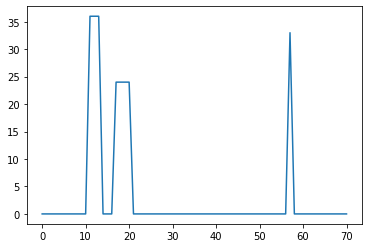

In [274]:
plt.plot(timeseries_test)
# plt.plot(timeseries_predict)

In [279]:
timeseries_predict

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [444]:
means = []
for t in test_processed.sort_values('timestamp')[['timestamp']].iterrows():
    try:
        a = gt[t[1].timestamp]
        b = p_ts[t[1].timestamp][0, 0, :, :, 0]
        mask_ = (a > 0)
        a = abs(b[mask_] - a[mask_])
        d = b[mask_]
        out = np.mean(np.divide(a, d, out=a.astype('float64'), where=d!=0))
        means.append(out)
    except:
        break

In [445]:
sum(means) / len(means)

8.69489836612638

In [450]:
test_processed

,hour,lat,lon,point,num_of_posts,error,timestamp
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00
...,...,...,...,...,...,...,...
695,1582059600,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,2020-02-18 21:00:00
696,1582038000,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,2020-02-18 15:00:00
697,1581926400,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,2020-02-17 08:00:00
698,1582099200,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,2020-02-19 08:00:00


In [453]:
means[:5]

[4.302185629058815, 4.302185629058815, 13.0, 8.0, 8.0]